# Nomad TCO Kaggle Competition
Goal: Predict band gap and formation energies using only basic geometric and atomic information from unit cell of transparent conducting oxides <br />
Code: 1) Loads geometries, 2) Engineers features from base data, 3) Tests multiple predictive models using sklearn
Best Yet: Light Gradient Boosting (lgb) using base features and bond length/coordination information

In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
import math
import numpy as np 
import pandas as pd 
import random

from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
from plotly import tools

import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import cross_val_score, ShuffleSplit, train_test_split, cross_validate
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn.decomposition import PCA
from scipy.spatial import ConvexHull
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uni

import sklearn.metrics as metrics
from sklearn.metrics.scorer import make_scorer

from sklearn.linear_model import LinearRegression

from sklearn.mixture import GaussianMixture
from sklearn.mixture import BayesianGaussianMixture
import itertools
from scipy import linalg

from sklearn.svm import SVR

from sklearn.multioutput import MultiOutputRegressor

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor

from sklearn.neural_network import MLPRegressor

import lightgbm as lgb
from lightgbm import LGBMRegressor
from lightgbm import LGBMClassifier

import xgboost

import networkx as nx

init_notebook_mode(connected=True)

In [2]:
print(os.getcwd())

C:\Users\Jonathan\Documents\Python Scripts\Kaggle\Nomad - TCO


# Scoring Functions

In [3]:
def mean_squared_log_error_JT(ground_truth, predictions):
    diff = np.power((np.log(predictions+1) - np.log(ground_truth+1)),2)
    return np.sqrt(np.average(diff))

## Load Data

In [4]:
dfTrain = pd.read_csv("data/train.csv")
dfTest = pd.read_csv("data/test.csv")
smplSub = pd.read_csv("sample_submission.csv")
assert(all(dfTrain.isnull().sum()) == False) # report if any missing data
assert(all(dfTest.isnull().sum()) == False) # report if any missing data

In [5]:
dfTrain.head()

,id,spacegroup,number_of_total_atoms,percent_atom_al,percent_atom_ga,percent_atom_in,lattice_vector_1_ang,lattice_vector_2_ang,lattice_vector_3_ang,lattice_angle_alpha_degree,lattice_angle_beta_degree,lattice_angle_gamma_degree,formation_energy_ev_natom,bandgap_energy_ev
0,1,33,80,0.6250,0.3750,0.000,9.9523,8.5513,9.1775,90.0026,90.0023,90.0017,0.0680,3.4387
1,2,194,80,0.6250,0.3750,0.000,6.1840,6.1838,23.6287,90.0186,89.9980,120.0025,0.2490,2.9210
2,3,227,40,0.8125,0.1875,0.000,9.7510,5.6595,13.9630,90.9688,91.1228,30.5185,0.1821,2.7438
3,4,167,30,0.7500,0.0000,0.250,5.0036,5.0034,13.5318,89.9888,90.0119,120.0017,0.2172,3.3492
4,5,194,80,0.0000,0.6250,0.375,6.6614,6.6612,24.5813,89.9960,90.0006,119.9893,0.0505,1.3793


## Feature Creation Functions

In [6]:
def LoadGeometries(folderPath):
    '''
    Function to read in geometry of each material, calculistLate necessary properties, and merge with original df to use as features
    Depends on following functions: LoadGeometry
    Inputs:
    1) folderPath: path to folder containing all subfolders for each geometry (1,2, etc.)
    '''
    dfToMerge = pd.DataFrame()
    
    folders = os.listdir(folderPath)
    for folder in folders:
        tmpMat = CalcGeometryFeatures(folderPath, folder)
        dfToMerge = dfToMerge.append(tmpMat)
    
    return dfToMerge

In [7]:
def LoadGeomPCAFeatures(folderPath):
    '''
    Function to read in geometry of each material, calculate PCA features, and create df that can be merged later
    with other feature df (e.g. LoadGeometries df)
    Depends on following functions: GeometryPCA
    Inputs:
    1) folderPath: path to folder containing all subfolders for each geometry (1,2, etc.)
    '''
    dfToMerge = pd.DataFrame()
    
    folders = os.listdir(folderPath)
    for folder in folders:
        tmpMat = GeometryPCA(folderPath, folder, plotFlag=False)
        dfToMerge = dfToMerge.append(tmpMat)
    
    return dfToMerge

In [8]:
def LoadDimPCAFeatures(folderPath):
    '''
    Function to read in geometry of each material, calculate dimension PCA features, and create df that can be merged later
    with other feature df (e.g. LoadGeometries df)
    Depends on following functions: DimensionPCA
    Inputs:
    1) folderPath: path to folder containing all subfolders for each geometry (1,2, etc.)
    '''
    dfToMerge = pd.DataFrame()
    
    folders = os.listdir(folderPath)
    for folder in folders:
        tmpMat = DimensionPCA(folderPath, folder)
        dfToMerge = dfToMerge.append(tmpMat)
    
    return dfToMerge

In [9]:
def DimensionPCA(folderPath, folder):
    '''
    Reads one geometry and calculates PCA transformation of the dimensions by atom type.
    This essentially provides an amount of variation of where that atom is relative to others.
    '''
    with open(folderPath + "/" + folder + "/geometry.xyz") as f:
        colAtom = ['atom', 'x', 'y', 'z'] # column names for atom-level df
        dfAtom = pd.DataFrame(columns = colAtom) # atom-level df
        
        colMatFeat = ['id']
        dfMat = pd.DataFrame(columns = colMatFeat, index = [0]) # material-level df
        if 'id' in colMatFeat:
            dfMat['id'] = folder # add id to df for merging later with original df
        
        lat = [] # tmp list for listLattice vector info
        for line in f.readlines(): # read geometry of material and put all atom and listLattice info into dfs
            split = line.split()
            if split[0] == "lattice_vector":
                latVectors = split[1:4]
                latVectors = [float(x) for x in latVectors]
                lat.append(latVectors) # store lattice vectors as floats
            if split[0] == "atom":
                data = split[1:5] # store atom positions
                dfAtom = dfAtom.append(pd.DataFrame([[data[3], float(data[0]),
                                                      float(data[1]), float(data[2])]],
                                                    columns = colAtom),
                                       ignore_index=True)  
    
    #Use PCA to calculate variation of each atom type
    for iAtom in ['Al', 'Ga', 'In', 'O']:
        dfSub = dfAtom[dfAtom['atom'] == iAtom]
        #Perform PCA if that element exists in this material
        if len(dfSub) > 1:
            #Only need two components for PCA, third will have no variability
            pca = PCA(n_components=2)
            transform = pca.fit_transform(dfSub[['x','y','z']].T)
            transform = transform.ravel()
        #If atom doesn't exist, set all to zero to show no variation
        else:
            transform = [0,0,0,0,0,0]
        for ele in range(len(transform)):
            dfMat[iAtom+str(ele)] = transform[ele]
    
    #Include number of O atoms
    dfMat['O Atoms'] = len(dfAtom[dfAtom['atom'] == 'O'])
    
    return dfMat

In [10]:
def GeometryPCA(folderPath, folder, plotFlag=False):
    '''
    Reads one geometry and calculates PCA transformation and plots 2d comparisons of axes
    Returns PCA coordinates
    Inputs:
    1) folderPath: path to folder containing all subfolders for each geometry (1,2, etc.)
    2) folder: folder for individual geometry with geometry.xyz file
    3) plotFlag: if True, plots the PCA results for that geometry
    '''
    with open(folderPath + "/" + folder + "/geometry.xyz") as f:
        colAtom = ['atom', 'x', 'y', 'z'] # column names for atom-level df
        dfAtom = pd.DataFrame(columns = colAtom) # atom-level df
        
        colMatFeat = ['id']
        dfMat = pd.DataFrame(columns = colMatFeat, index = [0]) # material-level df
        if 'id' in colMatFeat:
            dfMat['id'] = folder # add id to df for merging later with original df
        
        lat = [] # tmp list for listLattice vector info
        for line in f.readlines(): # read geometry of material and put all atom and listLattice info into dfs
            split = line.split()
            if split[0] == "lattice_vector":
                latVectors = split[1:4]
                latVectors = [float(x) for x in latVectors]
                lat.append(latVectors) # store lattice vectors as floats
            if split[0] == "atom":
                data = split[1:5] # store atom positions
                dfAtom = dfAtom.append(pd.DataFrame([[data[3], float(data[0]),
                                                      float(data[1]), float(data[2])]],
                                                    columns = colAtom),
                                       ignore_index=True)
    
    #Plot PCA analysis of coordinates
    pca, volume = PCAplot(dfAtom, plotFlag)

    #Feature: Add volume to feature list
    dfMat['Hull Volume'] = volume[0]
    dfMat['Hull Volume 1-2'] = volume[1]
    dfMat['Hull Volume 1-3'] = volume[2]
    dfMat['Hull Volume 2-3'] = volume[3]
    dfMat['Hull Volume Per Atom'] = volume[0] / len(dfAtom)
    dfMat['Hull Volume 1-2 Per Atom'] = volume[1] / len(dfAtom)
    dfMat['Hull Volume 1-3 Per Atom'] = volume[2] / len(dfAtom)
    dfMat['Hull Volume 2-3 Per Atom'] = volume[3] / len(dfAtom)
    
    #Feature: Count number of unique coordinate values along each PCA axis
    dfMat['Unique 1'] = len(set(np.round(pca,2)['1st']))
    dfMat['Unique 2'] = len(set(np.round(pca,2)['2nd']))
    dfMat['Unique 3'] = len(set(np.round(pca,2)['3rd']))
    
    #Feature: Calculate cluster features
    dfMat = CalcPCAClusterFeatures(dfMat, pca, ['1st', '2nd', '3rd'])
    
    return dfMat

In [11]:
def CalcPCAClusterFeatures(inDfMat, inDfPCA, colPCA):
    '''
    Calculates multiple features from PCA data using PCA coordinate matrix as input
    Use GMM to find cluster number with full covariance for elongated shapes.
    Input:
    1) inDfMat: df with calculated material properties that will be appended to final features list
    2) inDfPCA: df with 3 PCA directions (1st, 2nd, 3rd column names)
    3) colPCA: list of column names on which to perform PCA
    '''

    #Count number of clusters and clusters per atom in 3D
    bic3D = []
    for k in range(1,len(inDfPCA)):
        gmm = GaussianMixture(n_components = k, covariance_type = 'full',
                              init_params = 'kmeans', max_iter=300)
        gmm.fit(inDfPCA)
        gmm.predict(inDfPCA)
        bic3D.append(gmm.bic(inDfPCA))
    inDfMat['Clusters'] = np.argmin(bic3D)
    inDfMat['Clusters Per Atom'] = np.argmin(bic3D) / len(inDfPCA)
    
    #Count number of clusters and clusters per atom in each PCA direction
    listCluster = []
    for i in range(0,2):
        for j in range(i+1,3):
            dfInput = inDfPCA[[colPCA[i], colPCA[j]]] #set to current 2 PCA coordinate lists
            bic = [] #initialize list of bic scores
            
            #GMM loop over cluster number to find minimal bic score
            for k in range(1,len(dfInput)):
                gmm = GaussianMixture(n_components = k, covariance_type = 'full',
                                      init_params = 'kmeans', max_iter=300)
                gmm.fit(dfInput)
                gmm.predict(dfInput)
                bic.append(gmm.bic(dfInput))
            
            #Append cluster number with minium bic score, then do final GMM with that number
            #--CAN USE LATER FOR COVARIANCES AS FEATURES!
            listCluster.append(np.argmin(bic)+1)
            gmmFinal = GaussianMixture(n_components = (np.argmin(bic)+1), covariance_type = 'full',
                                      init_params = 'kmeans', max_iter=300)
            gmmFinal.fit(dfInput)
    
    inDfMat['Clusters 1-2'] = listCluster[0]
    inDfMat['Clusters 1-3'] = listCluster[1]
    inDfMat['Clusters 2-3'] = listCluster[2]
    inDfMat['Clusters 1-2 Per Atom'] = listCluster[0] / len(dfInput)
    inDfMat['Clusters 1-3 Per Atom'] = listCluster[1] / len(dfInput)
    inDfMat['Clusters 2-3 Per Atom'] = listCluster[2] / len(dfInput)
    
    return inDfMat

In [12]:
def plot_results(X, Y_, means, covariances, index, title):
    '''
    Function plots results of GMM clusteirng performed in CalcPCAClusterFeatures
    '''
    splot = plt.subplot(2, 1, 1 + index)
    for i, (mean, covar, color) in enumerate(zip(
            means, covariances, color_iter)):
        v, w = linalg.eigh(covar)
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        u = w[0] / linalg.norm(w[0])
        # as the DP will not use every component it has access to
        # unless it needs it, we shouldn't plot the redundant
        # components.
        if not np.any(Y_ == i):
            continue
        plt.scatter(X[Y_ == i, 0], X[Y_ == i, 1], .8, color=color)

        # Plot an ellipse to show the Gaussian component
        angle = np.arctan(u[1] / u[0])
        angle = 180. * angle / np.pi  # convert to degrees
        ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle, color=color)
        ell.set_clip_box(splot.bbox)
        ell.set_alpha(0.5)
        splot.add_artist(ell)

    plt.xlim(-9., 5.)
    plt.ylim(-3., 6.)
    plt.xticks(())
    plt.yticks(())
    plt.title(title)

#USAGE EXAMPLE
#X = np.asfarray(dfInput)
#gm = GaussianMixture(n_components = 11, covariance_type = 'full', max_iter=300)
#gm.fit(X)
#color_iter = itertools.cycle(['navy', 'blue', 'cornflowerblue', 'gold',
#                              'darkorange', 'orange'])
#plot_results(X, gm.predict(X), gm.means_, gm.covariances_, 1,
#             'GM')

In [13]:
def PCAplot(geom, plotFlag=False):
    '''
    Calculates PCA transformation of one geometry and returns coordinates and hull volumes
    Inputs:
    1) geom: dataframe with geometry for individual material
    '''
    #save coordinates and atomType (used for color)
    coord = geom[['x', 'y', 'z']]
    atomType = [str(i) for i in geom['atom']]
    dictColor = {'Al':'green', 'Ga':'red', 'In':'blue', 'O':'black'}
    
    #PCA transformation into matrix output for plotting
    coordPCA = PCA(n_components = 3).fit(coord).transform(coord)
    dfPCA = pd.DataFrame(coordPCA, columns = ['1st', '2nd', '3rd'])
    
    #Calculate values associated with PCA
    #Hull values
    h123 = ConvexHull(dfPCA.iloc[:][['1st', '2nd', '3rd']])
    vol123 = h123.volume
    h12 = ConvexHull(dfPCA.iloc[:][['1st', '2nd']])
    vol12 = h12.volume
    h13 = ConvexHull(dfPCA.iloc[:][['1st', '3rd']])
    vol13 = h13.volume
    h23 = ConvexHull(dfPCA.iloc[:][['2nd', '3rd']])
    vol23 = h23.volume
    
    #Plot coordinates with colored atoms and 1st 2 dimensions of PCA
    if plotFlag==True:
        fig = plt.figure(figsize=(15,15))
        ax1 = fig.add_subplot(221, projection='3d')
        ax1.scatter(coord[['x']], coord[['y']], coord[['z']], color = [dictColor[i] for i in atomType], alpha = 0.7)
        ax1.set_xlabel('X')
        ax1.set_ylabel('Y')
        ax1.set_zlabel('Z')
        
        ax2 = fig.add_subplot(222)
        ax2.scatter(dfPCA.iloc[:]['1st'], dfPCA.iloc[:]['2nd'], color = [dictColor[i] for i in atomType], alpha = 0.7)
        ax2.plot(dfPCA.loc[h12.vertices]['1st'], dfPCA.loc[h12.vertices]['2nd'], 'r-', lw=1)
        ax2.set_xlabel('1st component')
        ax2.set_ylabel('2nd component')

        ax3 = fig.add_subplot(223)
        ax3.scatter(dfPCA.iloc[:]['1st'], dfPCA.iloc[:]['3rd'], color = [dictColor[i] for i in atomType], alpha = 0.7)
        ax3.plot(dfPCA.loc[h13.vertices]['1st'], dfPCA.loc[h13.vertices]['3rd'], 'r-', lw=1)
        ax3.set_xlabel('1st component')
        ax3.set_ylabel('3rd component')

        ax4 = fig.add_subplot(224)
        ax4.scatter(dfPCA.iloc[:]['2nd'], dfPCA.iloc[:]['3rd'], color = [dictColor[i] for i in atomType], alpha = 0.7)
        ax4.plot(dfPCA.loc[h23.vertices]['2nd'], dfPCA.loc[h23.vertices]['3rd'], 'r-', lw=1)
        ax4.set_xlabel('2nd component')
        ax4.set_ylabel('3rd component')
    
    return dfPCA, [vol123, vol12, vol13, vol23]

In [14]:
def CalcGeometryFeatures(folderPath, folder):
    '''
    Reads one geometry and calculates all necessary features
    Inputs:
    1) folderPath: directoy with all subfolders for individual material geometries
    2) folder: folder with geometry.xyz file for one material
    '''
    with open(folderPath + "/" + folder + "/geometry.xyz") as f:
        colAtom = ['atom', 'x', 'y', 'z'] # column names for atom-level df
        dfAtom = pd.DataFrame(columns = colAtom) # atom-level df
        
        colMatFeat = ['id', 'xx', 'xy', 'xz', 'yx', 'yy', 'yz', 'zx', 'zy', 'zz']
        dfMat = pd.DataFrame(columns = colMatFeat, index = [0]) # material-level df
        if 'id' in colMatFeat:
            dfMat['id'] = folder # add id to df for merging later with original df
        
        lat = [] # tmp list for listLattice vector info
        for line in f.readlines(): # read geometry of material and put all atom and listLattice info into dfs
            split = line.split()
            if split[0] == "lattice_vector":
                latVectors = split[1:4]
                latVectors = [float(x) for x in latVectors]
                lat.append(latVectors) # store lattice vectors as floats
            if split[0] == "atom":
                data = split[1:5] # store atom positions
                dfAtom = dfAtom.append(pd.DataFrame([[data[3], float(data[0]),
                                                      float(data[1]), float(data[2])]],
                                                    columns = colAtom),
                                       ignore_index=True)
    
        # Save lattice vector information to dfMat
        dfMat = AddLattice(dfMat, colMatFeat, lat)
        
        #Calculate distances between all atoms using PBC's
        dfAtom = CalcDistances(dfAtom, lat, nndist1=1.2)
        
        # Bond lengths, NN distances, and coordination numbers
        #--For each atom type
        for atom in ['O', 'Ga', 'Al', 'In']:
            if len(dfAtom[dfAtom['atom'] == atom]) > 0:
                dfMat[atom + ' CN Avg'] = dfAtom.groupby('atom').mean().at[atom,'CN']
                dfMat[atom + ' CN Min'] = dfAtom.groupby('atom').min().at[atom,'CN']
                dfMat[atom + ' CN Max'] = dfAtom.groupby('atom').max().at[atom,'CN']
                dfMat[atom + '-O NN1 BL Avg'] = dfAtom.groupby('atom').mean().at[atom,'O NN1 BL']
                dfMat[atom + '-O NN1 BL Min'] = dfAtom.groupby('atom').min().at[atom,'O NN1 BL']
                dfMat[atom + '-O NN1 BL Max'] = dfAtom.groupby('atom').max().at[atom,'O NN1 BL']
                dfMat[atom + '-Ga NN1 BL Avg'] = dfAtom.groupby('atom').mean().at[atom,'Ga NN1 BL']
                dfMat[atom + '-Ga NN1 BL Min'] = dfAtom.groupby('atom').min().at[atom,'Ga NN1 BL']
                dfMat[atom + '-Ga NN1 BL Max'] = dfAtom.groupby('atom').max().at[atom,'Ga NN1 BL']
                dfMat[atom + '-Al NN1 BL Avg'] = dfAtom.groupby('atom').mean().at[atom,'Al NN1 BL']
                dfMat[atom + '-Al NN1 BL Min'] = dfAtom.groupby('atom').min().at[atom,'Al NN1 BL']
                dfMat[atom + '-Al NN1 BL Max'] = dfAtom.groupby('atom').max().at[atom,'Al NN1 BL']
                dfMat[atom + '-In NN1 BL Avg'] = dfAtom.groupby('atom').mean().at[atom,'In NN1 BL']
                dfMat[atom + '-In NN1 BL Min'] = dfAtom.groupby('atom').min().at[atom,'In NN1 BL']
                dfMat[atom + '-In NN1 BL Max'] = dfAtom.groupby('atom').max().at[atom,'In NN1 BL']
            
        # Bond angle
    
    return dfMat

In [15]:
def CalcDistances(df, lat, nndist1=1.2):
    '''
    1) Calculates bond lengths for 1st and 2nd nearest neighbors for each atom type
    2) Calculates coordination number of each atom
    Inputs:
    df: dataframe with atomic information for single material
    lat: lattice vectors
    nndist1: upper limit for 1st nearest neighbor distance (nndist1 times minimum distance between atoms)
    '''
    # Create columns:
    df['CN'] = np.nan #coordination number
    df['O NN1 BL'] = np.nan #average bond length of closest atom
    df['O NN1 Count'] = 0 #closest atom coordination number
    df['Ga NN1 BL'] = np.nan #average bond length of closest atom
    df['Ga NN1 Count'] = 0 #closest atom coordination number
    df['Al NN1 BL'] = np.nan #average bond length of closest atom
    df['Al NN1 Count'] = 0 #closest atom coordination number
    df['In NN1 BL'] = np.nan #average bond length of closest atom
    df['In NN1 Count'] = 0 #closest atom coordination number
    
    #Create reciprocal lattice vectors
    lat_r = np.linalg.inv(lat)
    
    # Cycle through each atom and calculate distance to all others
    for ind1 in df.index:
        tmpDist = [] #temporary list of distances
        tmpAtom = [] #temporary list of atom corresponding to each distance
        v1 = np.asfarray(df.iloc[ind1]['x':'z'])
        #v1_r = np.matmul(lat_r, v1) #represent v1 in recip. space
        # Loop over every other atom
        for ind2 in df.index:
            if ind1 != ind2:
                v2 = np.asfarray(df.iloc[ind2]['x':'z']) #other coordinates as np array
                #v2_r = np.matmul(lat_r, v2) #represent v2 in recip. space
                dist = DistancePBCreal(v1, v2, lat)
                tmpDist.append(dist) #distance list for one atom
                tmpAtom.append(df.at[ind2, 'atom']) #atoms at each distance
        tmpDf = pd.DataFrame(columns=['distance', 'atom'])
        tmpDf['distance'] = tmpDist
        tmpDf['atom'] = tmpAtom
        tmpDf = tmpDf.sort_values(by = ['distance'])
        
        #Calculate coordination number
        tmpCN = tmpDf[(tmpDf['distance'] >= min(tmpDf['distance'])) & (tmpDf['distance'] < nndist1*min(tmpDf['distance']))]
        df.at[ind1, 'CN'] = len(tmpCN.index)
        
        # Calculate all nn quantities for current atom BY ATOM TYPE
        # -Oxygen
        df = CalcNNCoordBondLength(df, tmpDf, 'O', 'O NN1 BL', 'O NN1 Count', ind1, nndist1)
        # -Gallium
        df = CalcNNCoordBondLength(df, tmpDf, 'Ga', 'Ga NN1 BL', 'Ga NN1 Count', ind1, nndist1)
        # -Aluminum
        df = CalcNNCoordBondLength(df, tmpDf, 'Al', 'Al NN1 BL', 'Al NN1 Count', ind1, nndist1)
        # -Indium
        df = CalcNNCoordBondLength(df, tmpDf, 'In', 'In NN1 BL', 'In NN1 Count', ind1, nndist1)
          
    return df

In [16]:
def CalcNNCoordBondLength(dfAtom, dfDist, atomType, col1, col2, index, nndist1):
    '''
    Function that takes distances as input to calculate 1) nearest neighbor distnaces,
    2) coordination numbers, 3) bond lengths for a given atom type (string)
    Inputs:
    1) dfAtom: df with atomic information
    2) dfDist: df with distance information between all atoms
    3) atomType: type of atom (must be one of possiblities from atom column)
    '''
    tmp = dfDist[dfDist['atom'] == atomType]
    if len(tmp) > 0:
        tmp1stNN = tmp[(tmp['distance'] >= min(tmp['distance'])) & (tmp['distance'] < nndist1*min(tmp['distance']))]
        dfAtom.at[index, col1] = np.average(tmp1stNN['distance'])
        dfAtom.at[index, col2] = len(tmp1stNN.index)
    
    return dfAtom

In [17]:
def AddLattice(df, cols, listLat):
    '''
    Adds lattice vector information to input df
    Used in following functions: CalcGeometryFeatures
    '''
    if 'xx' in cols:
        df['xx'] = listLat[0][0]
    if 'xy' in cols:
        df['xy'] = listLat[0][1]
    if 'xz' in cols:
        df['xz'] = listLat[0][2]
    if 'yx' in cols:
        df['yx'] = listLat[1][0]
    if 'yy' in cols:
        df['yy'] = listLat[1][1]
    if 'yz' in cols:
        df['yz'] = listLat[1][2]
    if 'zx' in cols:
        df['zx'] = listLat[2][0]
    if 'zy' in cols:
        df['zy'] = listLat[2][1]
    if 'zz' in cols:
        df['zz'] = listLat[2][2]    
    
    return df

In [18]:
def DistancePBCreal(v1, v2, lattice):
    '''
    Function to calculate distance, checking PBC, usingn real
    lattice vectors
    v1 - first vector in real space
    v2 - second vector in real space
    lattice - 3x3 lattice vectors
    '''
    lat = np.asfarray(lattice)
    
    dMin = np.inf
    
    for l in range(-1,2):
        for m in range(-1,2):
            for n in range(-1,2):
                v2_shift = v2 + l * lat[0] + m*lat[1] + n*lat[2]
                diff = abs(v2_shift - v1)
                d = np.linalg.norm(diff)
                if d < dMin:
                    dMin = d
    return dMin

In [19]:
def DistancePBCrecip(v1r, v2r, lattice):
    '''
    Function to calculate distance between two points, checking
    periodic boundary conditions for shortest distance
    Input:
    v1r - first vector in reciprocal space
    v2r - second vector in reciprocal space
    lattice- 3x3 matrix of lattice vectors (xx to zz)
    '''  
    vDiff_r = []
    
    for i, (a, b) in enumerate(zip(v1r, v2r)):
        diff = b - a
        if diff > 0.5: #check if over half the reduced lattice vector length away
            b = b-1
            diff = abs(b-a)
        if diff < -0.5:
            b = b+1
            diff = abs(b-a)
        vDiff_r.append(diff) #create difference vector in recip space
    return np.linalg.norm(np.matmul(lattice, vDiff_r)) #return distance of transformed difference

# Feature Creation

In [20]:
# Load all training geometries and create new features from them using distances
#dfTrainNewFeat = LoadGeometries('data/train')
#--Save Feature Data to csv to later load
#dfTrainNewFeat.to_csv('train_new_feat_1_11_18.csv')

In [21]:
# Load all testing geometries and create new features from them using distances
#dfTestNewFeat = LoadGeometries('data/test')
#--Save Test Feature Data to csv to later load
#dfTestNewFeat.to_csv('test_new_feat_1_11_18.csv')

In [22]:
# Load training geometries and calculate PCA clusters/features of geometry
#dfTrainPCAFeat = LoadGeomPCAFeatures('data/train')
# Save PCA features to csv to load later
#dfTrainPCAFeat.to_csv('train_pca_feat_1_10_2018.csv')

In [23]:
# Load test geometries and calculate PCA clusters/features of geometry
#dfTestPCAFeat = LoadGeomPCAFeatures('data/test')
# Save PCA features to csv to load later
#dfTestPCAFeat.to_csv('test_pca_feat_1_10_2018.csv')

In [24]:
# Load training geometries and calculate PCA dimension features for each atom type
#dfTrainDimPCAFeat = LoadDimPCAFeatures('data/train')
# Save PCA dimension features to csv to load later
#dfTrainDimPCAFeat.to_csv('train_dim_pca_1_15_2018.csv')

In [25]:
# Load test geometries and calculate PCA dimension features for each atom type
#dfTestDimPCAFeat = LoadDimPCAFeatures('data/test')
# Save test PCA dimension features to csv to load later
#dfTestDimPCAFeat.to_csv('test_dim_pca_1_15_2018.csv')

# Load Features Already Created Above

In [26]:
#--Load bond length and coordination feature data to prevent taking the time to recompute them
dfTrainNewFeat = pd.read_csv('train_new_feat_1_11_18.csv', index_col = 0)
dfTestNewFeat = pd.read_csv('test_new_feat_1_11_18.csv', index_col = 0)
#--Load PCA feature data to prevent taking the time to recompute them
dfTrainPCAFeat = pd.read_csv('train_pca_feat_1_10_2018.csv', index_col = 0)
dfTestPCAFeat = pd.read_csv('test_pca_feat_1_10_2018.csv', index_col = 0)
#--Load PCA dimension data to prevent taking the time to recompute them
dfTrainDimPCAFeat = pd.read_csv('train_dim_pca_1_15_2018.csv', index_col = 0)
dfTestDimPCAFeat = pd.read_csv('test_dim_pca_1_15_2018.csv', index_col = 0)

In [27]:
#Merge bond length and coordination features with original df
dfTrain = dfTrain.merge(dfTrainNewFeat, how='inner', on='id')
dfTest = dfTest.merge(dfTestNewFeat, how='inner', on='id')

In [28]:
#Merge PCA features with original df
dfTrain = dfTrain.merge(dfTrainPCAFeat, how='inner', on='id')
dfTest = dfTest.merge(dfTestPCAFeat, how='inner', on='id')

In [29]:
#Merge PCA dimension features with original
dfTrain = dfTrain.merge(dfTrainDimPCAFeat, how='inner', on='id')
dfTest = dfTest.merge(dfTestDimPCAFeat, how='inner', on='id')

## Additional Feature Generation

In [30]:
def CalcVolume(a, b, c, alpha, beta, gamma):
    """
    Parameters:
        a (float) - lattice vector 1
        b (float) - lattice vector 2
        c (float) - lattice vector 3
        alpha (float) - lattice angle 1 [radians]
        beta (float) - lattice angle 2 [radians]
        gamma (float) - lattice angle 3 [radians]
    Returns:
        volume (float) of the parallelepiped unit cell
    """
    return a*b*c*np.sqrt(1 + 2*np.cos(np.pi*alpha/180)*np.cos(np.pi*beta/180)*np.cos(np.pi*gamma/180)
                           - np.cos(np.pi*alpha/180)**2
                           - np.cos(np.pi*beta/180)**2
                           - np.cos(np.pi*gamma/180)**2)

In [31]:
#Calculate atomic quantities
dfTrain['Al Atoms'] = (dfTrain['number_of_total_atoms'] - dfTrain['O Atoms']) * dfTrain['percent_atom_al']
dfTrain['Ga Atoms'] = (dfTrain['number_of_total_atoms'] - dfTrain['O Atoms']) * dfTrain['percent_atom_ga']
dfTrain['In Atoms'] = (dfTrain['number_of_total_atoms'] - dfTrain['O Atoms']) * dfTrain['percent_atom_in']
dfTrain['Al-In Ratio'] = dfTrain['Al Atoms'] / dfTrain['In Atoms']
dfTrain['Al-Ga Ratio'] = dfTrain['Al Atoms'] / dfTrain['Ga Atoms']
dfTrain['Al-O Ratio'] = dfTrain['Al Atoms'] / dfTrain['O Atoms']
dfTrain['In-Ga Ratio'] = dfTrain['In Atoms'] / dfTrain['Ga Atoms']
dfTrain['In-O Ratio'] = dfTrain['In Atoms'] / dfTrain['O Atoms']
dfTrain['Ga-O Ratio'] = dfTrain['Ga Atoms'] / dfTrain['O Atoms']
dfTrain['Cation-O Ratio'] = (dfTrain['Al Atoms'] + dfTrain['Ga Atoms'] + dfTrain['In Atoms']) / dfTrain['O Atoms']

dfTest['Al Atoms'] = (dfTest['number_of_total_atoms'] - dfTest['O Atoms']) * dfTest['percent_atom_al']
dfTest['Ga Atoms'] = (dfTest['number_of_total_atoms'] - dfTest['O Atoms']) * dfTest['percent_atom_ga']
dfTest['In Atoms'] = (dfTest['number_of_total_atoms'] - dfTest['O Atoms']) * dfTest['percent_atom_in']
dfTest['Al-In Ratio'] = dfTest['Al Atoms'] / dfTest['In Atoms']
dfTest['Al-Ga Ratio'] = dfTest['Al Atoms'] / dfTest['Ga Atoms']
dfTest['Al-O Ratio'] = dfTest['Al Atoms'] / dfTest['O Atoms']
dfTest['In-Ga Ratio'] = dfTest['In Atoms'] / dfTest['Ga Atoms']
dfTest['In-O Ratio'] = dfTest['In Atoms'] / dfTest['O Atoms']
dfTest['Ga-O Ratio'] = dfTest['Ga Atoms'] / dfTest['O Atoms']
dfTest['Cation-O Ratio'] = (dfTest['Al Atoms'] + dfTest['Ga Atoms'] + dfTest['In Atoms']) / dfTest['O Atoms']

In [32]:
#Calculate generic cation-O bond lengths
dfTrain['Cation-O NN1 BL Avg'] = dfTrain[['Al-O NN1 BL Avg', 'In-O NN1 BL Avg', 'Ga-O NN1 BL Avg']].mean(skipna=True, axis=1)
dfTrain['Cation-O NN1 BL Min'] = dfTrain[['Al-O NN1 BL Min', 'In-O NN1 BL Min', 'Ga-O NN1 BL Min']].mean(skipna=True, axis=1)
dfTrain['Cation-O NN1 BL Max'] = dfTrain[['Al-O NN1 BL Max', 'In-O NN1 BL Max', 'Ga-O NN1 BL Max']].mean(skipna=True, axis=1)
dfTest['Cation-O NN1 BL Avg'] = dfTest[['Al-O NN1 BL Avg', 'In-O NN1 BL Avg', 'Ga-O NN1 BL Avg']].mean(skipna=True, axis=1)
dfTest['Cation-O NN1 BL Min'] = dfTest[['Al-O NN1 BL Min', 'In-O NN1 BL Min', 'Ga-O NN1 BL Min']].mean(skipna=True, axis=1)
dfTest['Cation-O NN1 BL Max'] = dfTest[['Al-O NN1 BL Max', 'In-O NN1 BL Max', 'Ga-O NN1 BL Max']].mean(skipna=True, axis=1)

In [33]:
#Calculate ranges of NN1 bond lengths
for atom1 in ['Al', 'Ga', 'In', 'O']:
    for atom2 in ['Al', 'Ga', 'In', 'O']:
        colNew = atom1+'-'+atom2+' NN1 BL Range'
        colMax = atom1+'-'+atom2+' NN1 BL Max'
        colMin = atom1+'-'+atom2+' NN1 BL Min'
        dfTrain[colNew] = dfTrain[colMax] - dfTrain[colMin]
        dfTest[colNew] = dfTest[colMax] - dfTest[colMin]

In [34]:
#Volume and atomic density
dfTrain['Volume'] = dfTrain.apply(lambda row: CalcVolume(row['lattice_vector_1_ang'], row['lattice_vector_2_ang'],
                                                         row['lattice_vector_3_ang'],
                                                         row['lattice_angle_alpha_degree'],
                                                         row['lattice_angle_beta_degree'],
                                                         row['lattice_angle_gamma_degree']), axis = 1)
dfTest['Volume'] = dfTest.apply(lambda row: CalcVolume(row['lattice_vector_1_ang'], row['lattice_vector_2_ang'],
                                                         row['lattice_vector_3_ang'],
                                                         row['lattice_angle_alpha_degree'],
                                                         row['lattice_angle_beta_degree'],
                                                         row['lattice_angle_gamma_degree']), axis = 1)
dfTrain['Atomic Density'] = dfTrain['number_of_total_atoms'] / dfTrain['Volume']
dfTest['Atomic Density'] = dfTest['number_of_total_atoms'] / dfTest['Volume']

In [35]:
#Mass and electronegativity
atomicNumAl = 13
atomicMassAl = 26.98
atomicNumGa = 31
atomicMassGa = 69.72
atomicNumIn = 49
atomicMassIn = 114.82
atomicNumO = 8
atomicMassO = 16.00
elenegAl = 1.61
elenegGa = 1.81
elenegIn = 1.78
elenegO = 3.44

dfTrain['Mass Total'] = dfTrain['Al Atoms']*atomicMassAl + dfTrain['Ga Atoms']*atomicMassGa + dfTrain['In Atoms']*atomicMassIn + dfTrain['O Atoms']*atomicMassO
dfTrain['Mass Avg'] = dfTrain['Mass Total'] / dfTrain['number_of_total_atoms']
dfTrain['Mass Density'] = dfTrain['Mass Total'] / dfTrain['Volume']
dfTrain['Electroneg Total'] = dfTrain['Al Atoms']*elenegAl + dfTrain['Ga Atoms']*elenegGa + dfTrain['In Atoms']*elenegIn + dfTrain['O Atoms']*elenegO
dfTrain['Electroneg Avg'] = dfTrain['Electroneg Total'] / dfTrain['number_of_total_atoms']
dfTrain['Electroneg Density'] = dfTrain['Electroneg Total'] / dfTrain['Volume']
dfTest['Mass Total'] = dfTest['Al Atoms']*atomicMassAl + dfTest['Ga Atoms']*atomicMassGa + dfTest['In Atoms']*atomicMassIn + dfTest['O Atoms']*atomicMassO
dfTest['Mass Density'] = dfTest['Mass Total'] / dfTest['Volume']
dfTest['Mass Avg'] = dfTest['Mass Total'] / dfTest['number_of_total_atoms']
dfTest['Electroneg Total'] = dfTest['Al Atoms']*elenegAl + dfTest['Ga Atoms']*elenegGa + dfTest['In Atoms']*elenegIn + dfTest['O Atoms']*elenegO
dfTest['Electroneg Avg'] = dfTest['Electroneg Total'] / dfTest['number_of_total_atoms']
dfTest['Electroneg Density'] = dfTest['Electroneg Total'] / dfTest['Volume']

In [36]:
#Ionization potential, EA, HOMO, LUMO, rd_max, rp_max, rs_max
eaAl = -0.2563
eaGa = -0.1081
eaIn = -0.3125
eaO = -0.2256
homoAl = -2.697
homoGa = -2.732
homoIn = -2.784
homoO = -2.740
lumoAl = 0.368
lumoGa = 0.130
lumoIn = 0.695
lumoO = 0.398
ipAl = -5.78
ipGa = -5.82
ipIn = -5.54
ipO = -5.71

dfTrain['EA Total'] = dfTrain['Al Atoms']*eaAl + dfTrain['Ga Atoms']*eaGa + dfTrain['In Atoms']*eaIn + dfTrain['O Atoms']*eaO
dfTrain['EA Avg'] = dfTrain['EA Total'] / dfTrain['number_of_total_atoms']
dfTrain['EA Density'] = dfTrain['EA Total'] / dfTrain['Volume']
dfTrain['IP Total'] = dfTrain['Al Atoms']*ipAl + dfTrain['Ga Atoms']*ipGa + dfTrain['In Atoms']*ipIn + dfTrain['O Atoms']*ipO
dfTrain['IP Avg'] = dfTrain['IP Total'] / dfTrain['number_of_total_atoms']
dfTrain['IP Density'] = dfTrain['IP Total'] / dfTrain['Volume']
dfTrain['HOMO Total'] = dfTrain['Al Atoms']*homoAl + dfTrain['Ga Atoms']*homoGa + dfTrain['In Atoms']*homoIn + dfTrain['O Atoms']*homoO
dfTrain['HOMO Avg'] = dfTrain['HOMO Total'] / dfTrain['number_of_total_atoms']
dfTrain['HOMO Density'] = dfTrain['HOMO Total'] / dfTrain['Volume']
dfTrain['LUMO Total'] = dfTrain['Al Atoms']*lumoAl + dfTrain['Ga Atoms']*lumoGa + dfTrain['In Atoms']*lumoIn + dfTrain['O Atoms']*lumoO
dfTrain['LUMO Avg'] = dfTrain['LUMO Total'] / dfTrain['number_of_total_atoms']
dfTrain['LUMO Density'] = dfTrain['LUMO Total'] / dfTrain['Volume']
dfTrain['Gap Total'] = dfTrain['LUMO Total'] - dfTrain['HOMO Total']
dfTrain['Gap Avg'] = dfTrain['LUMO Avg'] - dfTrain['HOMO Avg']
dfTrain['Gap Density'] = dfTrain['LUMO Density'] - dfTrain['HOMO Density']

dfTest['EA Total'] = dfTest['Al Atoms']*eaAl + dfTest['Ga Atoms']*eaGa + dfTest['In Atoms']*eaIn + dfTest['O Atoms']*eaO
dfTest['EA Avg'] = dfTest['EA Total'] / dfTest['number_of_total_atoms']
dfTest['EA Density'] = dfTest['EA Total'] / dfTest['Volume']
dfTest['IP Total'] = dfTest['Al Atoms']*ipAl + dfTest['Ga Atoms']*ipGa + dfTest['In Atoms']*ipIn + dfTest['O Atoms']*ipO
dfTest['IP Avg'] = dfTest['IP Total'] / dfTest['number_of_total_atoms']
dfTest['IP Density'] = dfTest['IP Total'] / dfTest['Volume']
dfTest['HOMO Total'] = dfTest['Al Atoms']*homoAl + dfTest['Ga Atoms']*homoGa + dfTest['In Atoms']*homoIn + dfTest['O Atoms']*homoO
dfTest['HOMO Avg'] = dfTest['HOMO Total'] / dfTest['number_of_total_atoms']
dfTest['HOMO Density'] = dfTest['HOMO Total'] / dfTest['Volume']
dfTest['LUMO Total'] = dfTest['Al Atoms']*lumoAl + dfTest['Ga Atoms']*lumoGa + dfTest['In Atoms']*lumoIn + dfTest['O Atoms']*lumoO
dfTest['LUMO Avg'] = dfTest['LUMO Total'] / dfTest['number_of_total_atoms']
dfTest['LUMO Density'] = dfTest['LUMO Total'] / dfTest['Volume']
dfTest['Gap Total'] = dfTest['LUMO Total'] - dfTest['HOMO Total']
dfTest['Gap Avg'] = dfTest['LUMO Avg'] - dfTest['HOMO Avg']
dfTest['Gap Density'] = dfTest['LUMO Density'] - dfTest['HOMO Density']

## Missing Data Resolution

Currently, missing data arises from that atom not being present in given material, so no bond distances or coordinations can be created.  Solution right now is to set this to 0 for inverse bond lengths and coordination, as this indicates that there is no coordination.  Then remove any columns with NaN.

In [51]:
#Fill in CN avg and std NaN with 0
#colCN = ['Al CN Avg', 'Al CN Min', 'Al CN Max', 'Ga CN Avg', 'Ga CN Min', 'Ga CN Max', 'In CN Avg', 'In CN Min', 'In CN Max']
#dfTrain[colCN] = dfTrain[colCN].fillna(0)
#dfTest[colCN] = dfTest[colCN].fillna(0)

### DROP NaN...

In [52]:
#dfTrain = dfTrain.dropna(axis = 1)
#dfTest = dfTest.dropna(axis = 1)

### OR REPLACE NaN WITH MEDIAN

In [53]:
dfTrain = dfTrain.replace([np.inf, -np.inf], np.nan)
dfTrain = dfTrain.fillna(dfTrain.median())
dfTest = dfTest.replace([np.inf, -np.inf], np.nan)
dfTest = dfTest.fillna(dfTest.median())

In [55]:
dfTrain.head()

,id,spacegroup,number_of_total_atoms,percent_atom_al,percent_atom_ga,percent_atom_in,lattice_vector_1_ang,lattice_vector_2_ang,lattice_vector_3_ang,lattice_angle_alpha_degree,...,nota_30,nota_40,nota_60,nota_80,spacegroup_12,spacegroup_33,spacegroup_167,spacegroup_194,spacegroup_206,spacegroup_227
0,1,33,80,0.6250,0.3750,0.000,9.9523,8.5513,9.1775,90.0026,...,0,0,0,1,0,1,0,0,0,0
1,2,194,80,0.6250,0.3750,0.000,6.1840,6.1838,23.6287,90.0186,...,0,0,0,1,0,0,0,1,0,0
2,3,227,40,0.8125,0.1875,0.000,9.7510,5.6595,13.9630,90.9688,...,0,1,0,0,0,0,0,0,0,1
3,4,167,30,0.7500,0.0000,0.250,5.0036,5.0034,13.5318,89.9888,...,1,0,0,0,0,0,1,0,0,0
4,5,194,80,0.0000,0.6250,0.375,6.6614,6.6612,24.5813,89.9960,...,0,0,0,1,0,0,0,1,0,0


In [56]:
#Target columns
targets = ['formation_energy_ev_natom', 'bandgap_energy_ev']
#Feature columns
features = list(set(list(dfTrain.columns)) - set(['id', 'formation_energy_ev_natom', 'bandgap_energy_ev']))

## Remove Outliers and Duplicates

In [57]:
#Outliers
dfTrain = dfTrain.drop([307, 1235, 1378, 1983, 2371])

## Training and Testing Choice and Scaling and PCA

In [58]:
modelFeatures = features

In [59]:
#--Set features to use
train = dfTrain[modelFeatures]
test = dfTest[modelFeatures]
target = dfTrain[targets]

In [60]:
#--Scale features
scalerStd = StandardScaler(with_mean=True, with_std=True)
scalerMM = MinMaxScaler(feature_range=(0,1))
#Apply scalers to train/test features and targets
trainStd = pd.DataFrame(scalerStd.fit_transform(train), columns=modelFeatures)
trainMM = pd.DataFrame(scalerMM.fit_transform(train), columns=modelFeatures)
targetStd = pd.DataFrame(scalerStd.fit_transform(target), columns=targets)
targetMM = pd.DataFrame(scalerMM.fit_transform(target), columns=targets)
testStd = pd.DataFrame(scalerStd.fit_transform(test), columns=modelFeatures)
testMM = pd.DataFrame(scalerMM.fit_transform(test), columns=modelFeatures)

In [61]:
#--PCA to uncorrelate features if necessary
pca = PCA(n_components=60)
trainPCA = pca.fit_transform(train)
testPCA = pca.transform(test)

pcaStd = PCA(n_components=60)
trainStdPCA = pcaStd.fit_transform(trainStd)
testStdPCA = pcaStd.transform(testStd)

pcaMM = PCA(n_components=60)
trainMMPCA = pcaMM.fit_transform(trainMM)
testMMPCA = pcaMM.transform(testMM)

In [62]:
pca = PCA(n_components=60)
testPCA = pca.fit_transform(trainStd)
pca.explained_variance_ratio_.sum()

0.98856243094492113

## Exploratory Data Analysis Using Plotly

### PCA - determine what features to extract from PCA
Ideas: hull volumes, some clustering ratio?  For example, for training data '2', 2nd and 3rd axes show clustering

In [ ]:
mat1 = GeometryPCA('data/train', '2', plotFlag=True)

### Correlations

In [170]:
#Correlations between features
featCol = features
corrFeat = trainStd[featCol].corr()
dataCorrFeat = [go.Heatmap(x = featCol, y = featCol, z = corrFeat.values,
                          zmin = -1, zmax = 1, showscale = True)]
layout = dict(title = 'Feature-Feature Correlation',
             xaxis = dict(title = 'Features', titlefont = dict(size = 18),
                          showticklabels = False, ticks = ""),
              yaxis = dict(title = 'Features', titlefont = dict(size = 18),
                          showticklabels = False, ticks = ""),
              width = 750, height = 750,
              autosize = False
              )
figure = dict(data = dataCorrFeat, layout = layout)
iplot(figure)

Conclusions: <br />
    - lattice_angle_beta_degree highly correlated with lattice_vector_1_ang.  Plot both together and combine as new feature?
    - number of atoms correlated with larger lattice vectors - self-explanatory.
    - space group correlated with larger lattice_vector_3_ang.  Any way to use this?

In [160]:
#Correlations between features and targets
corrAll = dfTrain[featCol + targets].corr()
dataCorrAll = [go.Heatmap(x = featCol, y = targets, z = corrAll.loc[targets, featCol].values,
                          zmin = -1, zmax = 1, showscale = True)]
layout = dict(title = 'Feature-Target Correlation',
              xaxis = dict(title = 'Features', titlefont = dict(size = 18),
                           showticklabels = False, ticks = ""),
              yaxis = dict(title = 'Targets', titlefont = dict(size = 18),
                           showticklabels = False, ticks = ""),
              width = 800, height = 250,
              autosize = False
              )
figure = dict(data = dataCorrAll, layout = layout)
iplot(figure)

### Exploratory plotting to determine relationships with targets

Possible actions:
    - remove outlier with 4 eV band gap but low max Al-O NN1 BL Max and O-O NN1 BL Max
    - combine O-O NN1 BL Avg, Min, Max or remove two of the three -all correlated above 0.98

In [ ]:
#Identify index of outliers
dfTrain[(dfTrain['bandgap_energy_ev'] > 4) & (dfTrain['O-O NN1 BL Avg'] < 2.4)]

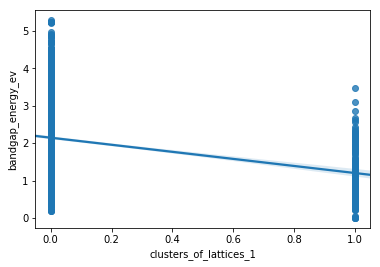

In [68]:
sns.regplot(dfTrain['clusters_of_lattices_1'], dfTrain['bandgap_energy_ev'])

In [ ]:
sns.regplot(dfTrain['O1'], dfTrain['bandgap_energy_ev'])

In [ ]:
sns.pointplot(dfTrain['O-O NN1 BL Min'], dfTrain['bandgap_energy_ev'])

In [ ]:
sns.pointplot(dfTrain['percent_atom_in'], dfTrain['formation_energy_ev_natom'])

In [ ]:
sns.pointplot(dfTrain['spacegroup'], dfTrain['bandgap_energy_ev'])

In [ ]:
sns.pointplot(dfTrain['Hull Volume'], dfTrain['bandgap_energy_ev'], linestyles='')

Very interesting relationships between Hull Volume and band gap within subset ranges of feature.  Need to do handmade feature engineering to capture these strong, local relationships

In [ ]:
sns.regplot(dfTrain['Clusters Per Atom'], dfTrain['bandgap_energy_ev'])

In [ ]:
sns.pointplot(dfTrain['Ga-O NN1 BL Avg'], dfTrain['bandgap_energy_ev'], linestyles='')

Ga-O NN1 BL Avg and Cation in general shows two clusters of relationships - need to separate two clustered relationships

In [ ]:
sns.regplot(dfTrain['EA Avg'], dfTrain['formation_energy_ev_natom'])

Conclusions: <br />
    - bandgap_energy_ev: most correlated to O-O bond length (min, avg), lower percent_atom_in and higher percent_atom_al - use both in initial model.  Should test polynomial features to get right degree.
    - formation_energy_ev_natom: not as highly correlated, but related to lattice_vector_3, percent_atom_ga, spacegroup
    - Hull Volume, BL ranges, others have interesting relationships with band gap for subset ranges - need to engineer by hand.

In [ ]:
dfCorr = train.corr()
for i in dfCorr.index:
    for j in dfCorr.columns:
        if (j>i and dfCorr.at[i,j] > 0.95):
            print(i, ' | ', j)

# Model Development

In [162]:
def NestedCV(inModel, inParams, inCVouter, inCVinner, inScorer, inTrain, inTarget, inTrainScore=True):
    '''
    Function performs inner and outer CV to optimize hyperparameters (inner) and then do performance estimation
    on separate CV split (outer)
    '''
    
    #Inner CV: to retrieve best parameters
    gs = GridSearchCV(inModel, inParams, cv = inCVinner, scoring = inScorer,
                      return_train_score = inTrainScore)
    gs.fit(inTrain, inTarget)
    gsBestScore = gs.best_score_
    gsBestParams = gs.best_params_
    gsResults = gs.cv_results_
    
    #Outer CV: Use best parameters with cross_val_score
    outerCV = cross_val_score(gs, inTrain, inTarget, cv = inCVouter)
    
    return outerCV, (gsBestScore, gsBestParams), gsResults

In [163]:
def LearningCurve(inMinSamples, inIntSamples, inModel, inCV, inTrain, inTarget, inScorer):
    '''
    Calculate learning curve using input model and training data.
    Fits model and performs cross-validation on increasing number of samples (rows).
    Plot result to determine whether high variance or high bias are issues to resolve.
    Parameters:
    inMinSamples: minimum number of samples on which to run model
    inIntSamples: interval for advancing sample number
    inModel: machine learning model object to use from sklearn
    inCV: cross-validation object (e.g. Shufflesplit)
    inTrain: training data in format compatible with sklearn
    inTarget: target data in format compatible with sklearn
    inScorer: scoring object compatible with cross_val_score
    '''
    listLearnSamples = []
    listLearnTrain = []
    listLearnTest = []
    for i in range(inMinSamples, len(inTrain), inIntSamples):
        if i % 500 == 0:
            print('Running model with ' + str(i) + ' samples...')
        indRnd = random.sample(range(0, len(inTrain)), i)
        trainIn = inTrain.loc[indRnd]
        testIn = inTarget.loc[indRnd]
        outCV = cross_validate(inModel, trainIn, testIn, cv = inCV,
                               scoring = inScorer, return_train_score=True)
        listLearnSamples.append(i)
        listLearnTrain.append(np.average(outCV['train_score']))
        listLearnTest.append(np.average(outCV['test_score']))
    
    return pd.DataFrame({'Samples':listLearnSamples, 'Train Score':listLearnTrain, 'Test Score':listLearnTest})

### Linear Regression

This is just a starting point to see what error we get with a basic polynomial regression and few features

In [ ]:
#--Cross-Validation to determine optimal polynomial - should use GridSearchCV next to use differen poly for each var
linFeatures = ['percent_atom_al', 'percent_atom_in', 'percent_atom_ga',
               'spacegroup',
               'lattice_vector_3_ang']
polys = 2
print("CV Results:")
print("-----------")
for poly in range(0,polys+1):
    # Create polynomial features
    pf = PolynomialFeatures(degree = poly)
    train_pf = pf.fit_transform(train[linFeatures])
    
    # Create linear regression object
    lr = LinearRegression(normalize = False)
    
    # Set up shuffle split for cross validation
    ss = ShuffleSplit(n_splits = 10, test_size = 0.20)
    
    # Perform cross-validation - take sqrt of MSLE for RMSLE as indicated in competition
    cvBG0 = cross_val_score(lr, train_pf, target['bandgap_energy_ev'],
                                    scoring = make_scorer(metrics.mean_squared_log_error),
                                    cv = ss))
    
    cvFE0 = cross_val_score(lr, train_pf, target['formation_energy_ev_natom'],
                                    scoring = make_scorer(metrics.mean_squared_log_error),
                                    cv = ss))
    
    avgBG0 = np.average(cvBG0)
    avgFE0 = np.average(cvFE0)
    avgFinal0 = 0.5 * (avgBG0 + avgFE0)

    print("Poly = %.0i, BG RMSLE = %.3f, FE RMSLE = %.3f, Final RMSLE = %.3f" % (poly, avgBG0, avgFE0, avgFinal0))    

In [ ]:
#Linear Regression - BG
#Features
linFeatures = ['percent_atom_al', 'percent_atom_in', 'percent_atom_ga',
               'spacegroup',
               'xx', 'xy', 'xz', 'yx', 'yy', 'yz', 'zx', 'zy', 'zz',
               'lattice_vector_3_ang',
               ]
# Create polynomial features
pf = PolynomialFeatures(degree = 2)
train_pf = pf.fit_transform(train[linFeatures])


#Model
lr = LinearRegression(normalize=False)
ssInner = ShuffleSplit(n_splits = 5, test_size = 0.20)
ssOuter = ShuffleSplit(n_splits = 10, test_size = 0.20)

paramsLR_BG = {'normalize':[False]}

nestedLRBGresults = NestedCV(lr, paramsLR_BG, ssOuter, ssInner,
                              metrics.make_scorer(mean_squared_log_error_JT, greater_is_better=False),
                              train_pf, target['bandgap_energy_ev'])
print('Outer CV Score: ', np.average(nestedLRBGresults[0]),
      '\nInner CV Score: ', nestedLRBGresults[1],
      '\nMean Test Score: ', nestedLRBGresults[2]['mean_test_score'],
      '\nMean Train Score: ', nestedLRBGresults[2]['mean_train_score'])

Conclusions: <br />
    - key variables to include are: percents of all atoms except Ga that doesn't matter (helps BG), percentGa and spacegroup and z-d listLattice vector (helps FE)
    - 3rd degree polynomial enough

In [ ]:
#--LR: Final fitting and prediction

pf = PolynomialFeatures(degree = 3)
train_pf = pf.fit_transform(train[linFeatures])
test_pf = pf.fit_transform(dfTest[linFeatures])
lr = LinearRegression(normalize = False)

# BG fitting and prediction
lr.fit(train_pf, target['bandgap_energy_ev'])
predBG = lr.predict(test_pf)

# FE fitting and prediction
lr.fit(train_pf, target['formation_energy_ev_natom'])
predFE = lr.predict(test_pf)

In [ ]:
#--LR: Create submission and save to csv
dfSubmit = pd.DataFrame(columns = ['formation_energy_ev_natom', 'bandgap_energy_ev'], index = dfTest['id'])
dfSubmit['formation_energy_ev_natom'] = predFE
dfSubmit['bandgap_energy_ev'] = predBG
dfSubmit.to_csv('lr_nomad_12272017.csv')

## SVM

Turns out that using higher C values, even if giving better test scores in GridSearch, still lead to overfitting and high variance when submitting to Kaggle!  C = 1 seems to be best so far - not sure I understand why!!
All Feature Notes: <br />
    - Set CN NaN values to 0, remove rest - this makes sense physically, as 0 has meaning (no coordination)
        - tranStd optimal: BG=0.088 for C = 1, eps = 0.01, 0.015 training discrepancy;
                           FE = 0.028 for C = 1, eps = 0.01
        - tranMM optimal: BG = 0.082 for C = 100, eps = 0.01
                           FE = 0.028 for C = 100, eps = 0.01
        
    - When including NaN = 0 and all features: much bigger difference between training and test scores - training are awesome!  Lots of variance b/c test scores higher
        - Need to figure out reason for overfitting - would a boost help?
        - With NaN = 0, BG testing scores much worse (much more variance) , not helped by Bagging, so need to use NaN removed for now
    - When excluding NaN and using all features:
        - trainStd optimal :kernel = rbf, C = 1, eps = 0.01 has gotten FE down to 0.031 average (better than reg), but BG still around 0.087
        - tranMM optimal: kernel = rbf, C = 1000, eps = 0.01 has gotten FE down to 0.033, BG = 0.085

In [ ]:
trainSvmBG = trainStd

#Band gap SVR GridSearch results
svrBG = SVR(kernel='rbf', C=1, epsilon=0.01)
ssOuter = ShuffleSplit(n_splits = 15, test_size = 0.20)
ssInner = ShuffleSplit(n_splits = 5, test_size = 0.20)

#Hyperparameters
svrParamBG = {'C':[1, 10, 100],
              'epsilon':[0.01]}

#Nested CV to optimize parameters
nestedSvmBGresults = NestedCV(svrBG, svrParamBG, ssOuter, ssInner,
                              metrics.make_scorer(mean_squared_log_error_JT, greater_is_better=False),
                              trainSvmBG, target['bandgap_energy_ev'])
print('Outer CV Score: ', np.average(nestedSvmBGresults[0]),
      '\nInner CV Score: ', nestedSvmBGresults[1],
      '\nMean Test Score: ', nestedSvmBGresults[2]['mean_test_score'],
      '\nMean Train Score: ', nestedSvmBGresults[2]['mean_train_score'])

In [ ]:
#SVM: Formation Energy
trainSvmFE = trainStd

#Band gap SVR GridSearch results
svrFE = SVR(kernel='rbf', C=1, epsilon=0.01)
ssOuter = ShuffleSplit(n_splits = 15, test_size = 0.20)
ssInner = ShuffleSplit(n_splits = 5, test_size = 0.20)

#Hyperparameters
svrParamFE = {'C':[1, 10, 100],
              'epsilon':[0.01]}

#Nested CV to optimize parameters
nestedSvmFEresults = NestedCV(svrFE, svrParamFE, ssOuter, ssInner,
                              metrics.make_scorer(mean_squared_log_error_JT, greater_is_better=False),
                              trainSvmFE, target['formation_energy_ev_natom'])
print('Outer CV Score: ', np.average(nestedSvmFEresults[0]),
      '\nInner CV Score: ', nestedSvmFEresults[1],
      '\nMean Test Score: ', nestedSvmFEresults[2]['mean_test_score'],
      '\nMean Train Score: ', nestedSvmFEresults[2]['mean_train_score'])

In [ ]:
#--SVM: Final fitting and prediction
# BG fitting and prediction
svrBG = SVR(kernel='rbf', C=1, epsilon=0.01)
svrBG.fit(trainStd, target['bandgap_energy_ev'])
predSvrBG = svrBG.predict(testStd)

# FE fitting and prediction
svrFE = SVR(kernel='rbf', C=1, epsilon=0.01)
svrFE.fit(trainStd, target['formation_energy_ev_natom'])
predSvrFE = svrFE.predict(testStd)

In [ ]:
#--SVM: Create submission and save to csv
dfSubmitSVR = pd.DataFrame(columns = ['formation_energy_ev_natom', 'bandgap_energy_ev'], index = dfTest['id'])
dfSubmitSVR['formation_energy_ev_natom'] = predSvrFE
dfSubmitSVR['bandgap_energy_ev'] = predSvrBG
dfSubmitSVR.to_csv('svr_nomad_Std_01152018.csv')

## Bagging Testing

### BaggingRegressor

Best Yet: <br />
    - BG: Bagging doesn't help!
        - 0.088 - BR: n_estimators: 25, max_features = 30, max_samples = 1.0, SVR: C = 1, eps = 0.01
    - FE: try to reduce variance by increasing n_est and decreasing max_samples, max_features, allows for higher C to fit better - bias-variance tradeoff
        - 0.025 - BR: n_estimators: 75, max_features = 30, max_samples = 0.5, SVR: C = 100, eps = 0.01
        - 0.029 - BR: n_estimators: 50, max_features = 40, max_samples = 1.0, SVR: C = 1, eps = 0.01
        - 0.028 - BR: n_estimators = 25, max_features = 30, max_samples = 0.5, SVR: C = 10, eps = 0.01

In [ ]:
trainBagBG = trainStd

#Band gap SVR GridSearch results
svrBG = SVR(kernel='rbf', C=1, epsilon=0.01)
BagSvrBG = BaggingRegressor(base_estimator=svrBG, n_estimators = 100, max_features=0.5, max_samples=0.5,
                          bootstrap=True, bootstrap_features=True)

ssOuter = ShuffleSplit(n_splits = 15, test_size = 0.20)
ssInner = ShuffleSplit(n_splits = 5, test_size = 0.20)

#Hyperparameters
BagSvrBG_param = {'n_estimators':[100, 300],
                  'max_features':[0.3],
                  'max_samples':[0.8]}

#Nested CV to optimize parameters
nestedBagSvmBGresults = NestedCV(BagSvrBG, BagSvrBG_param, ssOuter, ssInner,
                                 metrics.make_scorer(mean_squared_log_error_JT, greater_is_better=False),
                                 trainBagBG, target['bandgap_energy_ev'])
print('Outer CV Score: ', np.average(nestedBagSvmBGresults[0]),
      '\nInner CV Score: ', nestedBagSvmBGresults[1],
      '\nMean Test Score: ', nestedBagSvmBGresults[2]['mean_test_score'],
      '\nMean Train Score: ', nestedBagSvmBGresults[2]['mean_train_score'])

In [ ]:
trainBagFE = trainStd

#Band gap SVR GridSearch results
svrFE = SVR(kernel='rbf', C=1, epsilon=0.01)
BagSvrFE = BaggingRegressor(base_estimator=svrFE, n_estimators = 100, max_features=0.5, max_samples=0.5,
                          bootstrap=True, bootstrap_features=True)

ssOuter = ShuffleSplit(n_splits = 1, test_size = 0.20)
ssInner = ShuffleSplit(n_splits = 1, test_size = 0.20)

#Hyperparameters
BagSvrFE_param = {'n_estimators':[100, 300],
                  'max_features':[0.3],
                  'max_samples':[0.8]}

#Nested CV to optimize parameters
nestedBagSvmFEresults = NestedCV(BagSvrFE, BagSvrFE_param, ssOuter, ssInner,
                                 metrics.make_scorer(mean_squared_log_error_JT, greater_is_better=False),
                                 trainBagFE, target['bandgap_energy_ev'])
print('Outer CV Score: ', np.average(nestedBagSvmFEresults[0]),
      '\nInner CV Score: ', nestedBagSvmFEresults[1],
      '\nMean Test Score: ', nestedBagSvmFEresults[2]['mean_test_score'],
      '\nMean Train Score: ', nestedBagSvmFEresults[2]['mean_train_score'])

In [ ]:
#--Bagging Regressor with SVM: Final fitting and prediction
# Bagging for BG fitting and prediction
svrBG = SVR(kernel='rbf', C=1, epsilon=0.01)
BRsvrBG = BaggingRegressor(base_estimator=svrBG, n_estimators = 25, max_features=30, max_samples=1.0,
                          bootstrap=True, bootstrap_features=True)
BRsvrBG.fit(trainStd, target['bandgap_energy_ev'])
predBRsvrBG = BRsvrBG.predict(testStd)

# Bagging for FE fitting and prediction
svrFE = SVR(kernel='rbf', C=100, epsilon=0.01)
BRsvrFE = BaggingRegressor(base_estimator=svrFE, n_estimators = 75, max_features=30, max_samples=0.5,
                          bootstrap=True, bootstrap_features=True)
BRsvrFE.fit(trainStd, target['formation_energy_ev_natom'])
predBRsvrFE = BRsvrFE.predict(testStd)

In [ ]:
#--SVM: Create submission and save to csv
dfSubmitSVR = pd.DataFrame(columns = ['formation_energy_ev_natom', 'bandgap_energy_ev'], index = dfTest['id'])
dfSubmitSVR['formation_energy_ev_natom'] = predBRsvrFE
dfSubmitSVR['bandgap_energy_ev'] = predBRsvrBG
dfSubmitSVR.to_csv('svr_nomad_Bagging_01062018.csv')

### Random Forest

Rule of Thumb for optimizing RF: <br />
    - start with around 300 trees, 2 min_sample_split to determine splitting stop, then tune number of features used for each (max_feat)
    - from there, tune min_sample_split
    - then, tune number of trees (numEst)
Best so far:
    - BG = 0.0863 : numEst = 2000, min_sample_split = 4, min_sample_leaf = 1, max_features = 0.1
    - FE = 0.0275: numEst = 2000, min_sample_split = 2, min_sample_leaf = 1, max_features = 0.3
Other Notes:
    - Tried using PCA of features - first 10 capture 90% of variance, but when I use this the results are worse (~0.097) than using all features (~0.087) - why??

In [ ]:
#Training data
trainBG = train

#Model
rf = RandomForestRegressor(n_estimators = 2000,
                           criterion = 'mse',
                           max_depth=None, min_samples_split=4, min_samples_leaf=1,
                           min_weight_fraction_leaf=0.0, max_features=0.1,
                           max_leaf_nodes=None, bootstrap=True)
ssOuter = ShuffleSplit(n_splits = 5, test_size = 0.20)
ssInner = ShuffleSplit(n_splits = 15, test_size = 0.20)

#Hyperparameters
rfBG_param = {'n_estimators':[200, 300],
              'max_depth':[None],
              'min_samples_split':[4],
              'min_samples_leaf':[1],
              'max_features':[0.1],
              'max_leaf_nodes':[None]}


nestedRfBGresults = NestedCV(rf, rfBG_param, ssOuter, ssInner,
                              metrics.make_scorer(mean_squared_log_error_JT, greater_is_better=False),
                              trainBG, target['bandgap_energy_ev'])
print('Outer CV Score: ', np.average(nestedRfBGresults[0]),
      '\nInner CV Score: ', nestedRfBGresults[1],
      '\nMean Test Score: ', nestedRfBGresults[2]['mean_test_score'],
      '\nMean Train Score: ', nestedRfBGresults[2]['mean_train_score'])

In [ ]:
#Training data
trainFE = train

#Model
rf = RandomForestRegressor(n_estimators = 300,
                           criterion = 'mse',
                           max_depth=None, min_samples_split=4, min_samples_leaf=1,
                           min_weight_fraction_leaf=0.0, max_features='auto',
                           max_leaf_nodes=None, bootstrap=True)
ssOuter = ShuffleSplit(n_splits = 5, test_size = 0.20)
ssInner = ShuffleSplit(n_splits = 5, test_size = 0.20)

#Hyperparameters
rfFE_param = {'n_estimators':[300],
              'max_depth':[None],
              'min_samples_split':[4],
              'min_samples_leaf':[1],
              'max_features':[0.2],
              'max_leaf_nodes':[None]}


nestedRfFEresults = NestedCV(rf, rfFE_param, ssOuter, ssInner,
                              metrics.make_scorer(mean_squared_log_error_JT, greater_is_better=False),
                              trainFE, target['formation_energy_ev_natom'])
print('Outer CV Score: ', np.average(nestedRfFEresults[0]),
      '\nInner CV Score: ', nestedRfFEresults[1],
      '\nMean Test Score: ', nestedRfFEresults[2]['mean_test_score'],
      '\nMean Train Score: ', nestedRfFEresults[2]['mean_train_score'])

#### Check out where error is worst

BG: Error occuring for very low band gap, and then between 1-2 eV - need to improve this end of spectrum. <br />
FE: Some outliers at very high formation energy, need to address that.

In [ ]:
rfFinal = RandomForestRegressor(n_estimators = 2000,
                           criterion = 'mse',
                           max_depth=None, min_samples_split=2, min_samples_leaf=1,
                           min_weight_fraction_leaf=0.0, max_features=0.1,
                           max_leaf_nodes=None, bootstrap=True)
trainBG2, testBG2, trainBGout2, testBGout2 = train_test_split(trainingBG, target['bandgap_energy_ev'])
rfFinal.fit(trainBG2, trainBGout2)
BGpred = rfFinal.predict(testBG2)
rawError = BGpred - testBGout2
seriesError = np.sqrt(np.power((np.log(BGpred+1) - np.log(testBGout2+1)),2))
dfPlotError = pd.DataFrame(columns=['BG Error'])
dfPlotError['Raw Error'] = rawError
dfPlotError['BG Error'] = seriesError
dfPlotError['Band Gap'] = testBGout2
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.scatter(dfPlotError['Band Gap'], dfPlotError['BG Error'])
print(mean_squared_log_error_JT(BGpred, testBGout2))

In [ ]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.scatter(dfPlotError['Band Gap'], dfPlotError['Raw Error'])

In [ ]:
rfFinal = RandomForestRegressor(n_estimators = 300,
                           criterion = 'mse',
                           max_depth=None, min_samples_split=2, min_samples_leaf=1,
                           min_weight_fraction_leaf=0.0, max_features=0.5,
                           max_leaf_nodes=None, bootstrap=True)
trainFE2, testFE2, trainFEout2, testFEout2 = train_test_split(trainFE, target['formation_energy_ev_natom'])
rfFinal.fit(trainFE2, trainFEout2)
FEpred = rfFinal.predict(testFE2)
seriesError = np.sqrt(np.power((np.log(FEpred+1) - np.log(testFEout2+1)),2))
dfPlotError = pd.DataFrame(columns=['FE Error'])
dfPlotError['FE Error'] = seriesError
dfPlotError['Formation Energy'] = testFEout2
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.scatter(dfPlotError['Formation Energy'], dfPlotError['FE Error'])
#print(rfFinal.feature_importances_)
print(mean_squared_log_error_JT(FEpred, testFEout2))

In [ ]:
#--Random Forests: Final fitting and prediction
# RF for BG fitting and prediction
rfBG = RandomForestRegressor(n_estimators = 2000, criterion = 'mse', max_depth=None, min_samples_split=4,
                             min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=0.1,
                             max_leaf_nodes=None, bootstrap=True)
rfBG.fit(trainStd, target['bandgap_energy_ev'])
predrfBG = rfBG.predict(testStd)

# RF for FE fitting and prediction
rfFE = RandomForestRegressor(n_estimators = 2000, criterion = 'mse', max_depth=None, min_samples_split=2,
                             min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=0.3,
                             max_leaf_nodes=None, bootstrap=True)
rfFE.fit(trainStd, target['formation_energy_ev_natom'])
predrfFE = rfFE.predict(testStd)

In [ ]:
#--RF: Create submission and save to csv
dfSubmitRF = pd.DataFrame(columns = ['formation_energy_ev_natom', 'bandgap_energy_ev'], index = dfTest['id'])
dfSubmitRF['formation_energy_ev_natom'] = predrfFE
dfSubmitRF['bandgap_energy_ev'] = predrfBG
dfSubmitRF.to_csv('rf_nomad_RF_01132018.csv')

## Adaboost

### SVM

In [ ]:
# BG With SVR estimator
svr_for_AB = SVR(kernel='rbf', C=1, epsilon=0.01)
ABsvrBG = AdaBoostRegressor(base_estimator=svr_for_AB, n_estimators = 50, learning_rate=1.0, loss='linear')
ss = ShuffleSplit(n_splits = 5, test_size = 0.20)

In [ ]:
trainBG = train

In [ ]:
numEst = [50, 100, 150]
learnRate = [1.0]
loss = ['linear']
ABsvrBG_param = {'n_estimators':numEst, 'learning_rate':learnRate, 'loss':loss}
ABsvrBG_gs = GridSearchCV(ABsvrBG, ABsvrBG_param, cv = ss,
                     scoring=metrics.make_scorer(mean_squared_log_error_JT, greater_is_better=False),
                     return_train_score=True)
ABsvrBG_gs.fit(trainBG, target['bandgap_energy_ev'])
ABsvrBG_gs.cv_results_

In [ ]:
# FE With SVR estimator
svr_for_AB_FE = SVR(kernel='rbf', C=1, epsilon=0.01)
ABsvrFE = AdaBoostRegressor(base_estimator=svr_for_AB_FE, n_estimators = 50, learning_rate=1.0, loss='linear')
ss = ShuffleSplit(n_splits = 3, test_size = 0.20)

In [ ]:
numEst = [50]
learnRate = [1.0]
loss = ['linear']
ABsvrFE_param = {'n_estimators':numEst, 'learning_rate':learnRate, 'loss':loss}
ABsvrFE_gs = GridSearchCV(ABsvrFE, ABsvrFE_param, cv = ss,
                     scoring=metrics.make_scorer(mean_squared_log_error_JT),
                     return_train_score=True)
ABsvrFE_gs.fit(trainStd, target['formation_energy_ev_natom'])
ABsvrFE_gs.cv_results_

### Decision Trees

In [ ]:
# BG With DT estimator
dt_for_AB = DecisionTreeRegressor(criterion = 'mse', max_depth=6, min_samples_split=2, min_samples_leaf=1,
                                  min_weight_fraction_leaf=0.0, max_features=None,
                                  max_leaf_nodes=None)
ABdtBG = AdaBoostRegressor(base_estimator=dt_for_AB, n_estimators = 50, learning_rate=1.0, loss='linear')
ss = ShuffleSplit(n_splits = 5, test_size = 0.20)

In [ ]:
numEst = [500]
learnRate = [1.0]
loss = ['linear']
ABdtBG_param = {'n_estimators':numEst, 'learning_rate':learnRate, 'loss':loss}
ABdtBG_gs = GridSearchCV(ABdtBG, ABdtBG_param, cv = ss,
                     scoring=metrics.make_scorer(mean_squared_log_error_JT),
                     return_train_score=True)
ABdtBG_gs.fit(trainStd, target['bandgap_energy_ev'])
ABdtBG_gs.cv_results_

In [ ]:
# FE With DT estimator
dt_for_AB_FE = DecisionTreeRegressor(criterion = 'mse', max_depth=4, min_samples_split=2, min_samples_leaf=1,
                                  min_weight_fraction_leaf=0.0, max_features=None,
                                  max_leaf_nodes=None)
ABdtFE = AdaBoostRegressor(base_estimator=dt_for_AB_FE, n_estimators = 50, learning_rate=1.0, loss='linear')
ss = ShuffleSplit(n_splits = 25, test_size = 0.20)

In [ ]:
numEst = [50]
learnRate = [0.1, 0.5, 1.0]
loss = ['linear']
ABdtFE_param = {'n_estimators':numEst, 'learning_rate':learnRate, 'loss':loss}
ABdtFE_gs = GridSearchCV(ABdtFE, ABdtFE_param, cv = ss,
                     scoring=metrics.make_scorer(mean_squared_log_error_JT),
                     return_train_score=True)
ABdtFE_gs.fit(trainStd, target['bandgap_energy_ev'])
ABdtFE_gs.cv_results_

## Light Gradient Boosting (lgboost package)

In [ ]:
#Specific evaluation function of lgboost package
def mean_squared_log_error_JT_LGB(ground_truth, predictions):
    '''
    eval metric for lgb
    '''
    diff = np.power((np.log(predictions+1) - np.log(ground_truth+1)),2)
    return 'RMSLE', np.sqrt(np.average(diff)), False

In [ ]:
#One validation set to test lgboost package
X_train = train.head(2200)
X_val = train.tail(200)

target_train = target.head(2200)
target_val = target.tail(200)

y_train_1 = target_train['bandgap_energy_ev']
y_train_2 = target_train["formation_energy_ev_natom"]

y_val_1 = target_val['bandgap_energy_ev']
y_val_2 = target_val["formation_energy_ev_natom"]

In [ ]:
params = {
    'num_leaves': 7,
    'objective': 'regression',
    'min_data_in_leaf': 20,
    'learning_rate': 0.05,
    'feature_fraction': 0.93,
    'bagging_fraction': 0.93,
    'bagging_freq': 1,
    'metric': 'l2',
    'num_threads': 4
}

MAX_ROUNDS = 1400
val_pred = []
test_pred_1 = []
cate_vars = []

dtrain = lgb.Dataset(X_train, label=y_train_1,categorical_feature=cate_vars)

dval = lgb.Dataset(X_val, label=y_val_1, reference=dtrain,categorical_feature=cate_vars)

bst = lgb.train(params, dtrain, num_boost_round=MAX_ROUNDS,valid_sets=[dtrain, dval], early_stopping_rounds=50, verbose_eval=100)

print("\n".join(("%s: %.2f" % x) for x in sorted(zip(X_train.columns, bst.feature_importance("gain")),key=lambda x: x[1], reverse=True)))

val_pred.append(bst.predict(X_val, num_iteration=bst.best_iteration or MAX_ROUNDS))

test_pred_1.append(bst.predict(test, num_iteration=bst.best_iteration or MAX_ROUNDS))

In [ ]:
params = {
    'num_leaves': 7,
    'objective': 'regression',
    'min_data_in_leaf': 20,
    'learning_rate': 0.05,
    'feature_fraction': 0.93,
    'bagging_fraction': 0.93,
    'bagging_freq': 1,
    'metric': 'l2',
    'num_threads': 4
}

MAX_ROUNDS = 1400
val_pred = []
test_pred_2 = []
cate_vars = []

dtrain = lgb.Dataset(X_train, label=y_train_2,categorical_feature=cate_vars)

dval = lgb.Dataset(X_val, label=y_val_2, reference=dtrain,categorical_feature=cate_vars)

bst = lgb.train(params, dtrain, num_boost_round=MAX_ROUNDS,valid_sets=[dtrain, dval], early_stopping_rounds=50, verbose_eval=100)

print("\n".join(("%s: %.2f" % x) for x in sorted(zip(X_train.columns, bst.feature_importance("gain")),key=lambda x: x[1], reverse=True)))

val_pred.append(bst.predict(X_val, num_iteration=bst.best_iteration or MAX_ROUNDS))

test_pred_2.append(bst.predict(test, num_iteration=bst.best_iteration or MAX_ROUNDS))

In [ ]:
sample = pd.read_csv("sample_submission.csv")

sample["formation_energy_ev_natom"] = test_pred_2[0]
sample["bandgap_energy_ev"] = test_pred_1[0]

sample.to_csv("lgb_BaseFeatures_1_14_2018.csv",index = False)

## Light GBM in scikit-learn - true cross-validation

Current Thoughts:
    - if I use trainStdPCA with all components, 20 num_leaves, and 1100 iterations, get 0.001 train error but 0.093 test error - can I bring down overfitting a bit but still get lower test error?
Current Best:
    - 
    - BG: 0.079 
    - FE: 0.024
    - Together gives 0.0509 public LB score, but very stable CV here - I think it's because public LB is small amount of data.  Need to optimize parameters further.
    - Parameters:
    BG:
    train - need to optimize this number
    lgb_BG_Final = LGBMRegressor(boosting_type='gbdt', objective='regression',
                       num_leaves=10, max_depth=-1, learning_rate=0.03, n_estimators=1000,
                       subsample_for_bin=50000, class_weight=None,
                       min_split_gain=0.0, min_child_weight=0.001, min_child_samples=40,
                       subsample=0.80, subsample_freq=1, colsample_bytree=0.40,
                       reg_alpha=0.0, reg_lambda=0.0,
                       n_jobs=4, silent=False)
    train - need to optimize - may be better to use all 
    lgb_FE_Final = LGBMRegressor(boosting_type='gbdt', objective='regression',
                       num_leaves=10, max_depth=-1, learning_rate=0.03, n_estimators=1200,
                       subsample_for_bin=50000, class_weight=None,
                       min_split_gain=0.0, min_child_weight=0.001, min_child_samples=40,
                       subsample=0.80, subsample_freq=1, colsample_bytree=0.40,
                       reg_alpha=0.0, reg_lambda=0.0,
                       n_jobs=4, silent=False)
Feature Selection:
    - Remove 'Clusters' doesn't seem to help, and including htem helps leaderboard!

Notes:
    - Don't use scaled values for Light GBM - get much worse predictions!  Unless I haven't parametrized well enogh
    - Next steps: put standard CV procedure in place that stil uses early stopping - can't do with sklearn pipeline alone.

In [164]:
#Feature seleciton by KEEPING columns
colsKeep = ['O-O NN1 BL Avg', 'Cation-O NN1 BL Avg',
           'percent_atom_al', 'percent_atom_in', 'percent_atom_ga',
           'lattice_vector_1_ang', 'lattice_vector_2_ang', 'lattice_vector_3_ang',
           'lattice_angle_alpha_degree', 'lattice_angle_beta_degree', 'lattice_angle_gamma_degree',
           'number_of_total_atoms', 'spacegroup',
           'Al CN Avg', 'Al CN Max', 'Al CN Min',
           'Ga CN Avg', 'Ga CN Max', 'Ga CN Min',
           'Al-Al NN1 BL Avg', 'Al-Ga NN1 BL Avg', 'Al-In NN1 BL Avg',
           'Ga-Ga NN1 BL Avg', 'Ga-In NN1 BL Avg', 'In-In NN1 BL Avg',
           'Al-Al NN1 BL Range', 'Al-Ga NN1 BL Range', 'Al-In NN1 BL Range',
           'Ga-In NN1 BL Range', 'Ga-Ga NN1 BL Range', 'In-In NN1 BL Range',
           'Volume', 'Hull Volume 1-2', 'Hull Volume 1-3', 'Hull Volume 2-3',
           'Hull Volume Per Atom', 'Hull Volume 1-2 Per Atom', 'Hull Volume 1-3 Per Atom',
           'Hull Volume 2-3 Per Atom', 'Unique 1', 'Unique 2', 'Unique 3', 'Clusters',
           'Clusters 1-2', 'Clusters 1-3', 'Clusters 2-3',
           'Clusters 1-2 Per Atom', 'Clusters 1-3 Per Atom', 'Clusters 2-3 Per Atom',
           'O Atoms', 'Al Atoms', 'Ga Atoms', 'In Atoms',
           'Al-In Ratio', 'Al-Ga Ratio', 'In-Ga Ratio',
           'bucket1_sg', 'bucket2_sg', 'area_bucket_3', 'area_bucket_4',
           'nota_10', 'nota_20', 'nota_30', 'nota_40', 'nota_60',
           'spacegroup_33', 'spacegroup_206', 'spacegroup_227']
trainNew = train[colsKeep]
testNew = test[colsKeep]

In [ ]:
#Feature selection by REMOVING columns
colsRemove = ['lattice_angle_alpha_degree', 'lattice_angle_beta_degree', 'lattice_angle_gamma_degree']
subFeatures = list(set(list(train.columns)) - set(colsRemove))
trainNew = train[subFeatures]
testNew = test[subFeatures]

In [165]:
#Set training data here (testing removal of columns)
#trainBG = trainNew
#trainFE = trainNew
trainBG = train
trainFE = train

In [169]:
# BG Nested Cross Validation
lgb_BG = LGBMRegressor(boosting_type='gbdt', objective='regression',
                       num_leaves=10, max_depth=-1, learning_rate=0.03, n_estimators=1000,
                       subsample_for_bin=50000, class_weight=None,
                       min_split_gain=0.0, min_child_weight=0.001, min_child_samples=40,
                       subsample=0.80, subsample_freq=1, colsample_bytree=0.6,
                       reg_alpha=0.0, reg_lambda=0.0,
                       n_jobs=-1, silent=False)
ssInner = ShuffleSplit(n_splits = 5, test_size = 0.20)
ssOuter = ShuffleSplit(n_splits = 10, test_size = 0.20)
paramsLGB_BG = {'boosting_type':['gbdt'],
                'num_leaves':[10], #max leaves for base learner
                'max_depth':[-1], #max depth for base learner
                'learning_rate':[0.03],
                'n_estimators':[1200],
                'min_child_samples':[40], #minimum number of samples needed in leaf
                'min_split_gain':[0.0],
                'subsample':[0.8], #fraction of samples to use for each tree
                'subsample_freq':[1],
                'colsample_bytree':[0.6], #fraction of columns/features to use for each tree
                'reg_alpha':[0], #L1 regularization
                'reg_lambda':[0] #L2 regularization
                }

nestedLgbBGresults = NestedCV(lgb_BG, paramsLGB_BG, ssOuter, ssInner,
                              metrics.make_scorer(mean_squared_log_error_JT, greater_is_better=False),
                              trainBG, target['bandgap_energy_ev'])
print('Outer CV Score: ', np.average(nestedLgbBGresults[0]),
      '\nInner CV Score: ', nestedLgbBGresults[1],
      '\nMean Test Score: ', nestedLgbBGresults[2]['mean_test_score'],
      '\nMean Train Score: ', nestedLgbBGresults[2]['mean_train_score'])

Outer CV Score:  -0.0837860836829 
Inner CV Score:  (-0.084012547007176641, {'colsample_bytree': 0.2, 'subsample_freq': 1, 'min_child_samples': 30, 'max_depth': -1, 'num_leaves': 6, 'n_estimators': 1500, 'boosting_type': 'gbdt', 'reg_lambda': 2, 'min_split_gain': 0.0, 'learning_rate': 0.03, 'subsample': 0.8, 'reg_alpha': 0}) 
Mean Test Score:  [-0.08414211 -0.08423487 -0.08401255 -0.08438402] 
Mean Train Score:  [-0.047288   -0.04754834 -0.04786417 -0.0486665 ]


In [ ]:
# FE Fitting
lgb_FE = LGBMRegressor(boosting_type='gbdt', objective='regression',
                       num_leaves=12, max_depth=-1, learning_rate=0.05, n_estimators=1200,
                       subsample_for_bin=50000, class_weight=None,
                       min_split_gain=0.0, min_child_weight=0.001, min_child_samples=20,
                       subsample=0.80, subsample_freq=1, colsample_bytree=0.40,
                       reg_alpha=0.0, reg_lambda=0.0,
                       n_jobs=4, silent=False)
ssInner = ShuffleSplit(n_splits = 5, test_size = 0.20)
ssOuter = ShuffleSplit(n_splits = 25, test_size = 0.20)
paramsLGB_FE = {'boosting_type':['gbdt'],
                'num_leaves':[12],
                'max_depth':[-1],
                'learning_rate':[0.03],
                'n_estimators':[1200],
                'min_child_samples':[20],
                'min_split_gain':[0.0],
                'subsample':[0.8],
                'subsample_freq':[1],
                'colsample_bytree':[0.4],
                'reg_alpha':[0.0],
                'reg_lambda':[0.0]
                }

nestedLgbFEresults = NestedCV(lgb_FE, paramsLGB_FE, ssOuter, ssInner,
                              metrics.make_scorer(mean_squared_log_error_JT, greater_is_better=False),
                              trainFE, target['formation_energy_ev_natom'])
print('Outer CV Score: ', np.average(nestedLgbFEresults[0]),
      '\nInner CV Score: ', nestedLgbFEresults[1],
      '\nMean Test Score: ', nestedLgbFEresults[2]['mean_test_score'],
      '\nMean Train Score: ', nestedLgbFEresults[2]['mean_train_score'])

### Learning Curves

Graphs below indicate we are in high-variance, low-bias regime - should try to remove features since we cannot add more samples

In [ ]:
lgb_BG_lc = LGBMRegressor(boosting_type='gbdt', objective='regression',
                       num_leaves=10, max_depth=-1, learning_rate=0.03, n_estimators=1000,
                       subsample_for_bin=50000, class_weight=None,
                       min_split_gain=0.0, min_child_weight=0.001, min_child_samples=40,
                       subsample=0.80, subsample_freq=1, colsample_bytree=0.6,
                       reg_alpha=0.0, reg_lambda=10.0,
                       n_jobs=4, silent=False)

In [ ]:
minSamp = 150
intSamp = 50
ssLC = ShuffleSplit(n_splits = 10, test_size = 0.20)
dfLearnCurveBG = LearningCurve(minSamp, intSamp, lgb_BG_lc, ssLC, trainBG, target['bandgap_energy_ev'],
                            metrics.make_scorer(mean_squared_log_error_JT, greater_is_better=True))

In [ ]:
fig = plt.figure(figsize=(6,4))
ax1 = fig.add_subplot(111)
ax1.plot(dfLearnCurveBG['Samples'], dfLearnCurveBG['Train Score'], color='red', label='Train', linestyle='-', lw=2)
ax1.plot(dfLearnCurveBG['Samples'], dfLearnCurveBG['Test Score'], color='green', label='Test', linestyle='-', lw=2)
ax1.set_ylabel('Score')
ax1.legend()

In [ ]:
minSamp = 150
intSamp = 50
lgb_FE_lc = LGBMRegressor(boosting_type='gbdt', objective='regression',
                       num_leaves=10, max_depth=-1, learning_rate=0.03, n_estimators=1200,
                       subsample_for_bin=50000, class_weight=None,
                       min_split_gain=0.0, min_child_weight=0.001, min_child_samples=20,
                       subsample=0.80, subsample_freq=1, colsample_bytree=0.4,
                       reg_alpha=0.0, reg_lambda=0.0,
                       n_jobs=4, silent=False)
ssLC = ShuffleSplit(n_splits = 10, test_size = 0.20)
dfLearnCurveFE = LearningCurve(minSamp, intSamp, lgb_FE_lc, ssLC, trainBG, target['formation_energy_ev_natom'],
                               metrics.make_scorer(mean_squared_log_error_JT, greater_is_better=True))

In [ ]:
fig = plt.figure(figsize=(6,4))
ax1 = fig.add_subplot(111)
ax1.plot(dfLearnCurveFE['Samples'], dfLearnCurveFE['Train Score'], color='red', label='Train', linestyle='-', lw=2)
ax1.plot(dfLearnCurveFE['Samples'], dfLearnCurveFE['Test Score'], color='green', label='Test', linestyle='-', lw=2)
ax1.set_ylabel('Score')
ax1.legend()

#### Check where error is worst

In [ ]:
#Light GBM still doing much worse for low band gaps - same as RandomForest - how to improve this?!
trainBG2, testBG2, trainBGout2, testBGout2 = train_test_split(trainBG, target['bandgap_energy_ev'])
lgb_BG_lc.fit(trainBG2, trainBGout2)
BGpred = lgb_BG_lc.predict(testBG2)
rawError = BGpred - testBGout2
seriesError = np.sqrt(np.power((np.log(BGpred+1) - np.log(testBGout2+1)),2))
dfPlotErrorBGlgbm = pd.DataFrame(columns=['BG Error'])
dfPlotErrorBGlgbm['Raw Error'] = rawError
dfPlotErrorBGlgbm['BG Error'] = seriesError
dfPlotErrorBGlgbm['Band Gap'] = testBGout2
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.scatter(dfPlotErrorBGlgbm['Band Gap'], dfPlotErrorBGlgbm['BG Error'])
ax1.set_xlabel('Band Gap')
ax1.set_ylabel('Error')
print(mean_squared_log_error_JT(BGpred, testBGout2))

In [ ]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.scatter(dfPlotErrorBGlgbm['Band Gap'], dfPlotErrorBGlgbm['Raw Error'])
ax1.set_xlabel('Band Gap')
ax1.set_ylabel('Error')

In [ ]:
#Light GBM still doing much worse for higher formation energies - same as RandomForest - how to improve this?!
trainFE2, testFE2, trainFEout2, testFEout2 = train_test_split(trainFE, target['formation_energy_ev_natom'])
lgb_FE_lc.fit(trainFE2, trainFEout2)
FEpred = lgb_FE_lc.predict(testFE2)
seriesError = np.sqrt(np.power((np.log(FEpred+1) - np.log(testFEout2+1)),2))
dfPlotError = pd.DataFrame(columns=['FE Error'])
dfPlotError['FE Error'] = seriesError
dfPlotError['Formation Energy'] = testFEout2
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.scatter(dfPlotError['Formation Energy'], dfPlotError['FE Error'])
ax1.set_xlabel('Formation Energy')
ax1.set_ylabel('Error')
print(mean_squared_log_error_JT(FEpred, testFEout2))

In [ ]:
#Set testing data here for final fitting (testing removal of columns)
#testBG = testNew
#testFE = testNew
trainBG = train
trainFE = train
testBG = test
testFE = test

In [ ]:
# LGBM final fitting
lgb_BG_Final = LGBMRegressor(boosting_type='gbdt', objective='regression',
                       num_leaves=10, max_depth=-1, learning_rate=0.03, n_estimators=1000,
                       subsample_for_bin=50000, class_weight=None,
                       min_split_gain=0.0, min_child_weight=0.001, min_child_samples=40,
                       subsample=0.80, subsample_freq=1, colsample_bytree=0.60,
                       reg_alpha=0.0, reg_lambda=10.0,
                       n_jobs=4, silent=False)
lgb_BG_Final.fit(trainBG, target['bandgap_energy_ev'])
predLgbBG = lgb_BG_Final.predict(testBG)

In [ ]:
#Feature Importance by column
dictColumns = dict(zip(np.arange(0,len(trainBG.columns)), trainBG.columns))
listFeatImportBG = [(dictColumns[i], score) for i, score in enumerate(lgb_BG_Final.feature_importances_)]
listFeatImportBG.sort(key = lambda x: x[1], reverse=True)
listFeatImportBG

In [ ]:
# LGBM final fitting
lgb_FE_Final = LGBMRegressor(boosting_type='gbdt', objective='regression',
                       num_leaves=12, max_depth=-1, learning_rate=0.03, n_estimators=1200,
                       subsample_for_bin=50000, class_weight=None,
                       min_split_gain=0.0, min_child_weight=0.001, min_child_samples=20,
                       subsample=0.80, subsample_freq=1, colsample_bytree=0.60,
                       reg_alpha=0.0, reg_lambda=10.0,
                       n_jobs=4, silent=False)
lgb_FE_Final.fit(trainFE, target['formation_energy_ev_natom'])
predLgbFE = lgb_FE_Final.predict(testFE)

In [ ]:
print(predLgbBG[predLgbBG< 0])
print(predLgbFE[predLgbFE< 0])

In [ ]:
#--RF: Create submission and save to csv
dfSubmitLGB = pd.DataFrame(columns = ['formation_energy_ev_natom', 'bandgap_energy_ev'], index = dfTest['id'])
dfSubmitLGB['formation_energy_ev_natom'] = predLgbFE
dfSubmitLGB['bandgap_energy_ev'] = predLgbBG
dfSubmitLGB.to_csv('lgb_cv_nomad_AllFeatures_noscale_fracFeatures_02102018_1.csv')

In [ ]:
#Plot predicted in test vs train
fig = plt.figure(figsize=(5,2))
ax1 = fig.add_subplot(121)
ax1.hist(predLgbBG, color='blue', normed=True)
ax1.hist(target['bandgap_energy_ev'], color='red', alpha=0.5, normed=True)
ax2 = fig.add_subplot(122)
ax2.hist(predLgbFE, color='blue', normed=True)
ax2.hist(target['formation_energy_ev_natom'], color='red', alpha=0.5, normed=True)

## XGBoost

In [ ]:
trainBG = train
trainFE = train

In [ ]:
#BG: Xgboost
xgb = xgboost.XGBRegressor(learning_rate = 0.03, n_estimators= 2200, max_depth= 4,
                           min_child_weight= 6, gamma=0.0, subsample=0.8, colsample_bytree=0.4,
                           objective= 'reg:linear', nthread= -1, scale_pos_weight=1)

ssInner = ShuffleSplit(n_splits = 10, test_size = 0.20)
ssOuter = ShuffleSplit(n_splits = 5, test_size = 0.20)
paramsXGB_BG = {'learning_rate':[0.03],
                'n_estimators':[2200],
                'max_depth':[4],
                'min_child_weight':[6],
                'gamma':[0.0],
                'subsample':[0.8],
                'colsample_bytree':[0.4],
                'scale_pos_weight':[1]
                }

nestedXgbBGresults = NestedCV(xgb, paramsXGB_BG, ssOuter, ssInner,
                              metrics.make_scorer(mean_squared_log_error_JT, greater_is_better=False),
                              trainBG, target['bandgap_energy_ev'])
print('Outer CV Score: ', np.average(nestedXgbBGresults[0]),
      '\nInner CV Score: ', nestedXgbBGresults[1],
      '\nMean Test Score: ', nestedXgbBGresults[2]['mean_test_score'],
      '\nMean Train Score: ', nestedXgbBGresults[2]['mean_train_score'])

In [ ]:
#FE: Xgboost
xgb = xgboost.XGBRegressor(learning_rate = 0.03, n_estimators= 2000, max_depth= 4,
                           min_child_weight= 2, gamma=0.0, subsample=0.8, colsample_bytree=0.2,
                           objective= 'reg:linear', nthread= -1, scale_pos_weight=1)

ssInner = ShuffleSplit(n_splits = 10, test_size = 0.20)
ssOuter = ShuffleSplit(n_splits = 5, test_size = 0.20)
paramsXGB_FE = {'learning_rate':[0.03],
                'n_estimators':[2000],
                'max_depth':[4],
                'min_child_weight':[2],
                'gamma':[0.0],
                'subsample':[0.8],
                'colsample_bytree':[0.2],
                'scale_pos_weight':[1]
                }

nestedXgbFEresults = NestedCV(xgb, paramsXGB_FE, ssOuter, ssInner,
                              metrics.make_scorer(mean_squared_log_error_JT, greater_is_better=False),
                              trainBG, target['formation_energy_ev_natom'])
print('Outer CV Score: ', np.average(nestedXgbFEresults[0]),
      '\nInner CV Score: ', nestedXgbFEresults[1],
      '\nMean Test Score: ', nestedXgbFEresults[2]['mean_test_score'],
      '\nMean Train Score: ', nestedXgbFEresults[2]['mean_train_score'])

In [ ]:
#Light GBM still doing much worse for low band gaps - same as RandomForest - how to improve this?!
xgb_final = xgboost.XGBRegressor(learning_rate = 0.03, n_estimators= 2200, max_depth= 4,
                           min_child_weight= 6, gamma=0.0, subsample=0.8, colsample_bytree=0.4,
                           objective= 'reg:linear', nthread= -1, scale_pos_weight=1)
trainBG2, testBG2, trainBGout2, testBGout2 = train_test_split(trainBG, target['bandgap_energy_ev'])
xgb_final.fit(trainBG2, trainBGout2)
BGpred = xgb_final.predict(testBG2)
rawError = BGpred - testBGout2
seriesError = np.sqrt(np.power((np.log(BGpred+1) - np.log(testBGout2+1)),2))
dfPlotErrorBGlgbm = pd.DataFrame(columns=['BG Error'])
dfPlotErrorBGlgbm['Raw Error'] = rawError
dfPlotErrorBGlgbm['BG Error'] = seriesError
dfPlotErrorBGlgbm['Band Gap'] = testBGout2
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.scatter(dfPlotErrorBGlgbm['Band Gap'], dfPlotErrorBGlgbm['Raw Error'])
ax1.set_xlabel('Band Gap')
ax1.set_ylabel('Error')
print(mean_squared_log_error_JT(BGpred, testBGout2))

## Neural Networks

Thoughts so far:
    - trainStdPCA - with PCA - works much better for NN - not great for lightGBM!
    - 1000 in one layer, no alpha, tanh activation, learning_rate_init=0.01, adam best so far

In [ ]:
#Feature seleciton by KEEPING columns
colsKeep = ['O-O NN1 BL Avg Inv']
trainNew = train[colsKeep]
testNew = test[colsKeep]

In [ ]:
#Feature selection by REMOVING columns
colsRemove = ['xx', 'xy', 'xz', 'yx', 'yy', 'yz', 'zx', 'zy', 'zz']
subFeatures = list(set(list(train.columns)) - set(colsRemove))
trainNew = train[subFeatures]
testNew = test[subFeatures]

In [ ]:
#Set training data here (testing removal of columns)
#trainBG = trainNew
#trainFE = trainNew
trainBG = trainStdPCA
trainFE = trainStdPCA

In [ ]:
# BG Fitting - Neural Networks
mlp_BG = MLPRegressor(hidden_layer_sizes=(10000,), activation='tanh', alpha = 0.0001,
                      learning_rate='constant', learning_rate_init=0.01,
                      max_iter=1000, early_stopping=True,
                      solver='adam', beta_1=0.9, beta_2=0.999, epsilon=1e-8)
ss = ShuffleSplit(n_splits = 10, test_size = 0.20)
paramsMLP_BG = {'activation':['tanh'],
                'alpha':[0.0001],
                'learning_rate_init':[0.01],
                'max_iter':[2000]
                }

#Fit and CV
mlpBG_gs = GridSearchCV(mlp_BG, paramsMLP_BG, cv = ss,
                     scoring=metrics.make_scorer(mean_squared_log_error_JT, greater_is_better=False),
                     return_train_score=True)
mlpBG_gs.fit(trainBG, target['bandgap_energy_ev'])
mlpBG_best_score = mlpBG_gs.best_score_
mlpBG_best_params = mlpBG_gs.best_params_
mlpBG_gs.cv_results_

In [ ]:
print(mlpBG_gs.best_score_, mlpBG_gs.best_params_)

In [ ]:
# FE Fitting - Neural Networks
mlp_FE = MLPRegressor(hidden_layer_sizes=(1000,), activation='tanh', alpha = 0.0001,
                      learning_rate='constant', learning_rate_init=0.01,
                      max_iter=1000, early_stopping=True,
                      solver='adam', beta_1=0.9, beta_2=0.999, epsilon=1e-8)
ss = ShuffleSplit(n_splits = 10, test_size = 0.20)
paramsMLP_FE = {'activation':['tanh'],
                'alpha':[0.0001],
                'learning_rate_init':[0.01],
                'max_iter':[2000]
                }

#Fit and CV
mlpFE_gs = GridSearchCV(mlp_FE, paramsMLP_FE, cv = ss,
                     scoring=metrics.make_scorer(mean_squared_log_error_JT, greater_is_better=False),
                     return_train_score=True)
mlpFE_gs.fit(trainFE, target['formation_energy_ev_natom'])
mlpFE_best_score = mlpFE_gs.best_score_
mlpFE_best_params = mlpFE_gs.best_params_
mlpFE_gs.cv_results_

In [ ]:
#Set testing data here for final fitting (testing removal of columns)
#testBG = testNew
#testFE = testNew
testBG = testStdPCA
testFE = testStdPCA
mlp_BG = MLPRegressor(hidden_layer_sizes=(1000,), activation='tanh', alpha = 0.0001,
                      learning_rate='constant', learning_rate_init=0.01,
                      max_iter=1000, early_stopping=True,
                      solver='adam', beta_1=0.9, beta_2=0.999, epsilon=1e-8,
                      random_state=9)
mlp_BG.fit(trainBG, target['bandgap_energy_ev'])
mlp_BG.predict(testBG)

In [ ]:
mlp_BG.n_layers_

## Stacking Ensemble

Stack LGBM, RF, Adaboost, and SVM together, then use xgboost or linear regression for final combination.  Change this to use 5-fold on training set, then for each fold, combine the other four, use four training for base model, predict the other.  That way, use full training set for final second level prediction using xgboost.

In [ ]:
def StackedFirstLevelTraining(inFolds, inModel, inTrain, inTarget, colFold, colPred, colTarget):
    '''
    Runs model through n folds created from training set for first level of stacking model
    '''
    
    df = pd.DataFrame(columns = [colPred])
    for i in range(nFolds):
        featTrain = inTrain[inTrain[colFold] != i]
        targTrain = inTarget[inTarget[colFold] != i]
        featTest = inTrain[inTrain[colFold] == i]
        featTrain = featTrain.drop([colFold], axis = 1)
        targTrain = targTrain.drop([colFold], axis = 1)
        featTest = featTest.drop([colFold], axis = 1)
        inModel.fit(featTrain, targTrain[colTarget])
        inModel.predict(featTest)
        featTest[colPred] = inModel.predict(featTest)
        dfToAppend = featTest[[colPred]]
        df = df.append(dfToAppend)
    
    return df

In [ ]:
#Set folds and seed to use for reproducibilty
seed = 10
nFolds = 5

train['Fold Index'] = np.nan
trainStd['Fold Index'] = np.nan
target['Fold Index'] = np.nan
kfold5 = KFold(n_splits=nFolds, shuffle=True, random_state=seed)
#1) Break training set into 5 folds - use four of each as training to predict fifth with each base model.
for i, (train_index, test_index) in enumerate(kfold5.split(train)):
    train.loc[test_index,'Fold Index'] = i
    trainStd.loc[test_index,'Fold Index'] = i
    target.loc[test_index,'Fold Index'] = i
train['Fold Index'] = train['Fold Index'].astype('int32')
trainStd['Fold Index'] = trainStd['Fold Index'].astype('int32')
target['Fold Index'] = target['Fold Index'].astype('int32')

In [ ]:
#LGB
lgb_BG = LGBMRegressor(boosting_type='gbdt', objective='regression',
                       num_leaves=10, max_depth=-1, learning_rate=0.03, n_estimators=1000,
                       subsample_for_bin=50000, class_weight=None,
                       min_split_gain=0.0, min_child_weight=0.001, min_child_samples=40,
                       subsample=0.80, subsample_freq=1, colsample_bytree=0.6,
                       reg_alpha=0.0, reg_lambda=10.0,
                       n_jobs=-1, silent=False)
dfLGB_BG = StackedFirstLevelTraining(nFolds, lgb_BG, train, target, 'Fold Index', 'LGB Pred BG', 'bandgap_energy_ev')
lgb_FE = LGBMRegressor(boosting_type='gbdt', objective='regression',
                       num_leaves=12, max_depth=-1, learning_rate=0.03, n_estimators=1200,
                       subsample_for_bin=50000, class_weight=None,
                       min_split_gain=0.0, min_child_weight=0.001, min_child_samples=20,
                       subsample=0.80, subsample_freq=1, colsample_bytree=0.6,
                       reg_alpha=0.0, reg_lambda=10.0,
                       n_jobs=-1, silent=False)
dfLGB_FE = StackedFirstLevelTraining(nFolds, lgb_FE, train, target, 'Fold Index', 'LGB Pred FE', 'formation_energy_ev_natom')

In [ ]:
#RF
rf_BG = RandomForestRegressor(n_estimators = 2000,
                           criterion = 'mse',
                           max_depth=None, min_samples_split=4, min_samples_leaf=1,
                           min_weight_fraction_leaf=0.0, max_features=0.1,
                           max_leaf_nodes=None, bootstrap=True)
dfRF_BG = StackedFirstLevelTraining(nFolds, rf_BG, train, target, 'Fold Index', 'RF Pred BG', 'bandgap_energy_ev')
rf_FE = RandomForestRegressor(n_estimators = 2000,
                           criterion = 'mse',
                           max_depth=None, min_samples_split=2, min_samples_leaf=1,
                           min_weight_fraction_leaf=0.0, max_features=0.3,
                           max_leaf_nodes=None, bootstrap=True)
dfRF_FE = StackedFirstLevelTraining(nFolds, rf_FE, train, target, 'Fold Index', 'RF Pred FE', 'formation_energy_ev_natom')

In [ ]:
#SVM
svm_BG = SVR(kernel='rbf', C=1, epsilon=0.01)
dfSVM_BG = StackedFirstLevelTraining(nFolds, svm_BG, trainStd, target, 'Fold Index', 'SVM Pred BG', 'bandgap_energy_ev')
svm_FE = SVR(kernel='rbf', C=1, epsilon=0.01)
dfSVM_FE = StackedFirstLevelTraining(nFolds, svm_FE, trainStd, target, 'Fold Index', 'SVM Pred FE', 'formation_energy_ev_natom')

In [ ]:
#XGBoost
xgb_BG = xgboost.XGBRegressor(learning_rate = 0.03, n_estimators= 2200, max_depth= 4,
                           min_child_weight= 6, gamma=0.0, subsample=0.8, colsample_bytree=0.4,
                           objective= 'reg:linear', nthread= -1, scale_pos_weight=1)
dfXGB_BG = StackedFirstLevelTraining(nFolds, xgb_BG, train, target, 'Fold Index', 'XGB Pred BG', 'bandgap_energy_ev')
xgb_FE = xgboost.XGBRegressor(learning_rate = 0.03, n_estimators= 2000, max_depth= 4,
                           min_child_weight= 2, gamma=0.0, subsample=0.8, colsample_bytree=0.2,
                           objective= 'reg:linear', nthread= -1, scale_pos_weight=1)
dfXGB_FE = StackedFirstLevelTraining(nFolds, xgb_FE, train, target, 'Fold Index', 'XGB Pred FE', 'formation_energy_ev_natom')

In [ ]:
dfFirstFinal = dfLGB_BG.join([dfRF_BG, dfSVM_BG, dfXGB_BG, dfLGB_FE, dfRF_FE, dfSVM_FE, dfXGB_FE])
dfFirstFinal.sort_index(inplace=True)
dfFirstFinal.head()

In [ ]:
#Heat map for correlation - all correlated!
sns.heatmap(dfFirstFinal.corr())

In [ ]:
#Second level Xgboost
trainBG = train

xgb2 = xgboost.XGBRegressor(learning_rate = 0.03, n_estimators= 1000, max_depth= 4,
                           min_child_weight= 4, gamma=0.0, subsample=0.8, colsample_bytree=1,
                           objective= 'reg:linear', nthread= -1, scale_pos_weight=1)

ssInner = ShuffleSplit(n_splits = 5, test_size = 0.20)
ssOuter = ShuffleSplit(n_splits = 100, test_size = 0.20)
paramsXGB2_BG = {'learning_rate':[0.03],
                'n_estimators':[200],
                'max_depth':[4],
                'min_child_weight':[8],
                'gamma':[0.0],
                'subsample':[0.2],
                'colsample_bytree':[1],
                'scale_pos_weight':[1]
                }

nested2ndBGresults = NestedCV(xgb2, paramsXGB2_BG, ssOuter, ssInner,
                              metrics.make_scorer(mean_squared_log_error_JT, greater_is_better=False),
                              dfFirstFinal, target['bandgap_energy_ev'])
print('Outer CV Score: ', np.average(nested2ndBGresults[0]),
      '\nInner CV Score: ', nested2ndBGresults[1],
      '\nMean Test Score: ', nested2ndBGresults[2]['mean_test_score'],
      '\nMean Train Score: ', nested2ndBGresults[2]['mean_train_score'])

In [ ]:
#Second level LR
pf = PolynomialFeatures(degree = 1)
firstFinal_pf = pf.fit_transform(dfFirstFinal)

ssInner = ShuffleSplit(n_splits = 5, test_size = 0.20)
ssOuter = ShuffleSplit(n_splits = 100, test_size = 0.20)

lr = LinearRegression(normalize = False)

paramsLR_BG = {'normalize':[False]}

nested2ndLrBGresults = NestedCV(lr, paramsLR_BG, ssOuter, ssInner,
                              metrics.make_scorer(mean_squared_log_error_JT, greater_is_better=False),
                              firstFinal_pf, target['bandgap_energy_ev'])
print('Outer CV Score: ', np.average(nested2ndLrBGresults[0]),
      '\nInner CV Score: ', nested2ndLrBGresults[1],
      '\nMean Test Score: ', nested2ndLrBGresults[2]['mean_test_score'],
      '\nMean Train Score: ', nested2ndLrBGresults[2]['mean_train_score'])

In [ ]:
#Second level LR
trainFE = train

ssInner = ShuffleSplit(n_splits = 5, test_size = 0.20)
ssOuter = ShuffleSplit(n_splits = 100, test_size = 0.20)

lr = LinearRegression(normalize = False)

paramsLR_FE = {'normalize':[False]}

nested2ndLrFEresults = NestedCV(lr, paramsLR_FE, ssOuter, ssInner,
                              metrics.make_scorer(mean_squared_log_error_JT, greater_is_better=False),
                              dfFirstFinal, target['formation_energy_ev_natom'])
print('Outer CV Score: ', np.average(nested2ndLrFEresults[0]),
      '\nInner CV Score: ', nested2ndLrFEresults[1],
      '\nMean Test Score: ', nested2ndLrFEresults[2]['mean_test_score'],
      '\nMean Train Score: ', nested2ndLrFEresults[2]['mean_train_score'])

In [ ]:
dfFirstFinal

In [ ]:
#Final predictions using fitted models on first level of stacking
dfTestFirst = pd.DataFrame()
dfTestFirst['LGB Pred BG'] = lgb_BG.predict(test)
dfTestFirst['RF Pred BG'] = rf_BG.predict(test)
dfTestFirst['SVM Pred BG'] = svm_BG.predict(testStd)
dfTestFirst['XGB Pred BG'] = xgb_BG.predict(test)
dfTestFirst['LGB Pred FE'] = lgb_FE.predict(test)
dfTestFirst['RF Pred FE'] = rf_FE.predict(test)
dfTestFirst['SVM Pred FE'] = svm_FE.predict(testStd)
dfTestFirst['XGB Pred FE'] = xgb_FE.predict(test)

In [ ]:
#Final predictions on second level for submission
lrFinal_BG = LinearRegression(normalize=False)
lrFinal_BG.fit(dfFirstFinal, target['bandgap_energy_ev'])
lrFinal_FE = LinearRegression(normalize=False)
lrFinal_FE.fit(dfFirstFinal, target['formation_energy_ev_natom'])

predStackedFinal_BG = lrFinal_BG.predict(dfTestFirst)
predStackedFinal_FE = lrFinal_FE.predict(dfTestFirst)

In [ ]:
#--RF: Create submission and save to csv
dfSubmitStack = pd.DataFrame(columns = ['formation_energy_ev_natom', 'bandgap_energy_ev'], index = dfTest['id'])
dfSubmitStack['formation_energy_ev_natom'] = predStackedFinal_FE
dfSubmitStack['bandgap_energy_ev'] = predStackedFinal_BG
dfSubmitStack.to_csv('lgb_cv_nomad_AllFeatures_STACKED_02102018_1.csv')